This file processes and plots output from GP Microbiome using functions and loops, then saves the results. For the CF data, the input files for this program were created in the program readsample27_with_151_edit from GP Microbiome output files. This version uses as input randomly generated example csv files, which are not actually output from GP Microbiome, but are designed to resemble it. I have included these files in this repository so that you can run the program as it is written and see the output for yourself. The code itself is identical to the code that I used, except for file names and a few comments. I have included those comments and file names for the convenience of those also working with the CF data. I have also included in this repository a full explanation of how I generated the example data for those who are interested. 

<br>
The functions produce as many as twenty plots for each participant, and when run in a loop generate plots for all participants at once. The plots use colour-coded markers to indicate the participant's clinical condition at each time point, a desirable feature which Python currently has no built-in mechanism for. To create plots with shaded backgrounds indicating binary variables over time - another type of visualisation that is not directly built in to matplotlib - see Plots_Shaded_Backgrounds. 

<br>

The code may easily be adapted to other types of data, in a variety of situations involving generating any number of easily comparable plots, showing predicted and actual values, and indicating factor variables at distinct points in time.

In [1]:
#import necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Section 1
The first few cells create the OTUkey_named file. If the file has already been created, you can skip down to Section 2.


In [2]:
#add a column for only the bacteria's genus name to the OTU key file
key = pd.read_excel("Data/OTUkey.xlsx")
#rename first column to avoid Excel mistaking it for a SYLK file due to the "ID" in the name
key.rename(columns={'ID_OTU': 'OTU'}, inplace=True)
key.head()

OTU                                           Bacteria
0  OTU_1  D_0__Bacteria;D_1__Actinobacteria;D_2__Acidimi...
1  OTU_2  D_0__Bacteria;D_1__Actinobacteria;D_2__Actinob...
2  OTU_3  D_0__Bacteria;D_1__Actinobacteria;D_2__Actinob...
3  OTU_4  D_0__Bacteria;D_1__Actinobacteria;D_2__Actinob...
4  OTU_5  D_0__Bacteria;D_1__Actinobacteria;D_2__Actinob...

In [48]:
#extract the genus from the taxonomic information
pat = 'D_5__(?P<Name>.*)'
key=key.join(key.Bacteria.str.extract(pat, expand=True))
key.head()

OTU                                           Bacteria  \
0  OTU_1  D_0__Bacteria;D_1__Actinobacteria;D_2__Acidimi...   
1  OTU_2  D_0__Bacteria;D_1__Actinobacteria;D_2__Actinob...   
2  OTU_3  D_0__Bacteria;D_1__Actinobacteria;D_2__Actinob...   
3  OTU_4  D_0__Bacteria;D_1__Actinobacteria;D_2__Actinob...   
4  OTU_5  D_0__Bacteria;D_1__Actinobacteria;D_2__Actinob...   

                   Name  
0  uncultured bacterium  
1           Actinomyces  
2       Bifidobacterium  
3             Scardovia  
4                   NaN

In [49]:
#replace NaN, which occurs where the genus is "Other", with the word "Other"
key['Name'].fillna('Other', inplace=True)
key.head()
#save edited file
key.to_csv("Data/OTUkey_named.csv", index=False)

OTU                                           Bacteria  \
0  OTU_1  D_0__Bacteria;D_1__Actinobacteria;D_2__Acidimi...   
1  OTU_2  D_0__Bacteria;D_1__Actinobacteria;D_2__Actinob...   
2  OTU_3  D_0__Bacteria;D_1__Actinobacteria;D_2__Actinob...   
3  OTU_4  D_0__Bacteria;D_1__Actinobacteria;D_2__Actinob...   
4  OTU_5  D_0__Bacteria;D_1__Actinobacteria;D_2__Actinob...   

                   Name  
0  uncultured bacterium  
1           Actinomyces  
2       Bifidobacterium  
3             Scardovia  
4                 Other

## Section 2
Read in the OTUkey_named file below if it already exists.

In [3]:
#read in OTUkey_named file, if it has already been created 
key=pd.read_csv("Data/OTUkey_named.csv")

In [4]:
#make a list of the OTU IDs for our bacteria of interest
bacteria=[2,30,58,59,60,63,70,80,94,104,113,167,169,170,206,221,223,227,229,234]

## Section 3
This section creates a second version of the OTUkey_named file for selected bacteria for use in other programs, and can also be skipped once you have the file. We will use a version of the OTUkey_named_selection file, with plot specifcations added, in DTW_All_boxplots, where we create boxplots of the TIME Dynamic Time Warping output.

In [52]:
#this cell can be skipped if the OTUkey_selection_named file already exists, as it is not used in this particular program.
#creating a second key for selected bacteria
selectkey=key.iloc[[i-1 for i in bacteria],:]
selectkey.head()
#saving the select key for later use in other programs
selectkey.to_csv("Data/OTUkey_named_selection.csv", index=False)

OTU                                           Bacteria            Name
1    OTU_2  D_0__Bacteria;D_1__Actinobacteria;D_2__Actinob...     Actinomyces
29  OTU_30  D_0__Bacteria;D_1__Actinobacteria;D_2__Actinob...          Rothia
57  OTU_58  D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroi...   Porphyromonas
58  OTU_59  D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroi...  Alloprevotella
59  OTU_60  D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroi...      Prevotella

## Section 4: Plots
Read the files into dictionaries and plot them with functions. The dictionaries are to facilitate plotting multiple particpants' output at once in loops. If you only have one file, you can run the function on just that participant ID or create a 1-item dictionary. If you really don't want to bother with dictionaries, you can read each file in manually and use them as parameters for the alternative plotting functions in Section 5. Section 5 also contains notes on how one would plot between-time-points predictions by themselves, for those who are interested.
<br>
See Section 6 for the code to create legends, with options to save the legends as separate files (my preferred method for the CF output data) or to copy and paste into any of the functions in Section 4 and 5 at the indicated places.

## Part A: Read in files

First we read in our example output csv files, which are intended to resemble real output and are not actually the results of running GP Microbiome and processing the raw output with the program readsample27. I have included in this repository a full explanation of how I created them for those who are interested. 

<br>
See readsample27_with_151_edit for the actual code I used to process the output from running GP Microbiome on the CF Data.

In [2]:
#create a list for the ID numbers of the participants whose data we ran through GPMicrobiome and wish to plot
IDs=['405','453','480','500','511']
#Create dictionaries and read in each person's output for noise free compositions without predictions, 
#and both with and without predictions. 
dfs = {i: pd.read_csv('Data/{}.csv'.format(i)) for i in IDs}
both_dfs = {i: pd.read_csv('Data/{}_both.csv'.format(i)) for i in IDs}


In [ ]:
#if we were running this on the CF Data, we would simply change the IDs list:
#IDs=['151','708','759','764','768']

In [3]:
#check that it ran correctly by looking at the first few entries for one of the files without predictions
dfs['511'].head() 

0      1           2      3            4       5           6
0  0.0  198.0  554.000000  761.0  1183.000000  1334.0  1579.00000
1  0.0    0.0    0.000000    0.0     0.000000     0.0     0.00000
2  0.0    0.0    0.001559    0.0     0.004858     0.0     0.00077
3  0.0    0.0    0.000000    0.0     0.000000     0.0     0.00000
4  0.0    0.0    0.000000    0.0     0.000000     0.0     0.00000

In [4]:
#check again that the code ran correctly by looking at the head of one of the files with both actual and predicted values
both_dfs['511'].head()

0      1           2      3            4       5           6     7  \
0  0.0  198.0  554.000000  761.0  1183.000000  1334.0  1579.00000  99.0   
1  0.0    0.0    0.000000    0.0     0.000000     0.0     0.00000   0.0   
2  0.0    0.0    0.001559    0.0     0.004858     0.0     0.00077   0.0   
3  0.0    0.0    0.000000    0.0     0.000000     0.0     0.00000   0.0   
4  0.0    0.0    0.000000    0.0     0.000000     0.0     0.00000   0.0   

       8          9     10           11      12           13           14  \
0  376.0  657.00000  901.0  1042.000000  1268.0  1456.000000  1759.000000   
1    0.0    0.00000    0.0     0.000000     0.0     0.000000     0.000000   
2    0.0    0.00165    0.0     0.005896     0.0     0.000676     0.000685   
3    0.0    0.00000    0.0     0.000000     0.0     0.000000     0.000000   
4    0.0    0.00000    0.0     0.000000     0.0     0.000000     0.000000   

            15          16  
0  1939.000000  2119.00000  
1     0.000000     0.00000  
2     0.000592     0.00066  
3     0.000000     0.00000  
4     0.000000     0.00000

In [5]:
#rename the columns in the files containing both sets of time points based on the first row, which contains the time points
#then reorder the columns in the files to make the time points consecutive, and put them in a new dictionary
reordered_dfs={}
for i in IDs:
    df=both_dfs[i].set_axis(both_dfs[i].loc[0].tolist(), axis=1, inplace=False)
    df=df.reindex(columns=sorted(df.columns))
    #save file if desired 
    df.to_csv('Data/{}_both_reordered.csv'.format(i), index=False)
    reordered_dfs[i]=df

In [6]:
#check that the redordering code ran correctly by looking at the head and comparing with the other two
reordered_dfs['511'].head()

0.0     99.0    198.0   376.0       554.0      657.0   761.0   901.0   \
0     0.0    99.0   198.0   376.0  554.000000  657.00000   761.0   901.0   
1     0.0     0.0     0.0     0.0    0.000000    0.00000     0.0     0.0   
2     0.0     0.0     0.0     0.0    0.001559    0.00165     0.0     0.0   
3     0.0     0.0     0.0     0.0    0.000000    0.00000     0.0     0.0   
4     0.0     0.0     0.0     0.0    0.000000    0.00000     0.0     0.0   

        1042.0       1183.0  1268.0  1334.0       1456.0      1579.0  \
0  1042.000000  1183.000000  1268.0  1334.0  1456.000000  1579.00000   
1     0.000000     0.000000     0.0     0.0     0.000000     0.00000   
2     0.005896     0.004858     0.0     0.0     0.000676     0.00077   
3     0.000000     0.000000     0.0     0.0     0.000000     0.00000   
4     0.000000     0.000000     0.0     0.0     0.000000     0.00000   

        1759.0       1939.0      2119.0  
0  1759.000000  1939.000000  2119.00000  
1     0.000000     0.000000     0.00000  
2     0.000685     0.000592     0.00066  
3     0.000000     0.000000     0.00000  
4     0.000000     0.000000     0.00000

In [7]:
#read in the files containing the observed relative abundance data for each participant, adding them to a new dictionary
#the columns are the age in days at the time of each sample, and we will use this information as well in the plots
rel_dfs = {i: pd.read_csv("Data/{}_Rel.csv".format(i)) for i in IDs}

In [8]:
#examine the head of one of the files to confirm it ran correctly
rel_dfs['511'].head()

242  440       796  1003     1425      1576      1821
0  0.000000  0.0  0.000000   0.0  0.00000  0.000000  0.000000
1  0.000464  0.0  0.001883   0.0  0.00565  0.009478  0.000942
2  0.000000  0.0  0.000000   0.0  0.00000  0.000000  0.000000
3  0.000000  0.0  0.000000   0.0  0.00000  0.000000  0.000000
4  0.000942  0.0  0.000000   0.0  0.00000  0.000000  0.000000

## Part B: Markers, two ways
In our plots, different coloured markers indicate a participant's clinical condition. There are two main ways of creating dictionaries for the markers: One is to import metadata and process it into dictionaries directly. The other is, after doing the first method once and saving the results to an Excel file (in my case, the same metadata file), to import those results into dictionaries. The first method is more flexible, since it goes directly to the metadata, but the code for the second has useful applications beyond this program. Easily generalised, it shows how to force Python to recognize lists from a saved file as lists rather than strings. 

## First Method: Creating markers directly


In [9]:
#read in the metadata file which includes the condition and time delta for each participant's samples 
status=pd.read_excel("Data/ExampleDeltaKey.xlsx", sheet_name="Metadata and time deltas")
#for the CF Data, the name of the file is 'MetaDataKey.xlsx'
#otherwise, the code is identical

In [10]:
#create a dictionary which, for each participant, lists the time deltas for samples taken while stable
S_list={}
for i in [int(x) for x in IDs]:
    #convert to a list, for each ID, the entries in the Time_Delta column for which the Visit_type was 'Stable'
    S_list[i]=list(status.query('Participant == {} and Visit_type == "Stable"'.format(i))['Time_Delta'])
#display to confirm
S_list

{405: [0, 629, 855, 1223],
 453: [0, 404, 754, 1377, 1515],
 480: [118, 368, 909, 1303, 1493],
 500: [0, 250, 1467],
 511: [554, 1183, 1334]}

In [11]:
#create a dictionary which, for each participant, lists the time deltas for samples taken during exacerbations
E_list={}
for i in [int(x) for x in IDs]:
    #convert to a list, for each ID, the entries in the Time_Delta column for which the Visit_type was 'Exacerbation'
    E_list[i]=list(status.query('Participant == {} and Visit_type == "Exacerbation"'.format(i))['Time_Delta'])
#display to confirm
E_list

{405: [176, 544, 1079, 1392, 1595],
 453: [520, 832, 1135],
 480: [0, 555, 695, 1041, 1181, 1723],
 500: [427, 925, 1135, 1309],
 511: [0, 198, 761, 1579]}

In [12]:
#make a dictionary depicting the order of the values in the lists contained in S_list, which will be for green markers
#these are for use with plots without predictions
#this corresponds to column names in the 'dfs' dictionary, which are simple index values 
markers_gdict={}
for i in IDs:
    markers_gdict[i]=[int(col) for col in dfs[i].columns if dfs[i][col][0] in S_list[int(i)]]
#make a dictionary depicting the order of the values in the lists contained in E_list, which will be for red markers
markers_rdict={}
for i in IDs:
    markers_rdict[i]=[int(col) for col in dfs[i].columns if dfs[i][col][0] in E_list[int(i)]]
#display to confirm
markers_gdict, markers_rdict

({'405': [0, 3, 4, 6],
  '453': [0, 1, 3, 6, 7],
  '480': [1, 2, 5, 8, 9],
  '500': [0, 1, 6],
  '511': [2, 4, 5]},
 {'405': [1, 2, 5, 7, 8],
  '453': [2, 4, 5],
  '480': [0, 3, 4, 6, 7, 10],
  '500': [2, 3, 4, 5],
  '511': [0, 1, 3, 6]})

In [13]:
#make a dictionary depicting the order of the values in the lists contained in S_list, which will be for green markers
#these are for use with plots with predictions
#this corresponds to index values of column names in the 'reordered_dfs' dictionary 
#which are time deltas for both actual and predicted values
#if you did not predict between samples, you can use markers_g again for these plots because predicted values aren't marked
markers_g1dict={}
for i in IDs:
    markers_g1dict[i]=[reordered_dfs[i].columns.get_loc(col) for col in reordered_dfs[i].columns 
                    if reordered_dfs[i][col][0] in S_list[int(i)]]
#make a dictionary depicting the order of the values in the lists contained in E_list, which will be for red markers
#if you did not predict between samples, you can use markers_r again for these plots
markers_r1dict={}
for i in IDs:
    markers_r1dict[i]=[reordered_dfs[i].columns.get_loc(col) for col in reordered_dfs[i].columns 
                    if reordered_dfs[i][col][0] in E_list[int(i)]]
#display to confirm
markers_g1dict, markers_r1dict

({'405': [0, 7, 9, 13],
  '453': [0, 3, 7, 13, 15],
  '480': [2, 4, 10, 16, 18],
  '500': [0, 2, 13],
  '511': [4, 9, 11]},
 {'405': [2, 5, 11, 15, 17],
  '453': [5, 9, 11],
  '480': [0, 6, 8, 12, 14, 20],
  '500': [4, 7, 9, 11],
  '511': [0, 2, 6, 13]})

In [14]:
#convert to a data frame
data={'markers_r': markers_rdict, 'markers_g': markers_gdict, 'markers_r1':markers_r1dict, 'markers_g1':markers_g1dict}
#make it oriented with participants as columns and the names of the dictionaries as rows
df=pd.DataFrame.from_dict(data, orient='index')
#view the head
df.head()

405                453                    480  \
markers_g         [0, 3, 4, 6]    [0, 1, 3, 6, 7]        [1, 2, 5, 8, 9]   
markers_g1       [0, 7, 9, 13]  [0, 3, 7, 13, 15]     [2, 4, 10, 16, 18]   
markers_r      [1, 2, 5, 7, 8]          [2, 4, 5]    [0, 3, 4, 6, 7, 10]   
markers_r1  [2, 5, 11, 15, 17]         [5, 9, 11]  [0, 6, 8, 12, 14, 20]   

                      500            511  
markers_g       [0, 1, 6]      [2, 4, 5]  
markers_g1     [0, 2, 13]     [4, 9, 11]  
markers_r    [2, 3, 4, 5]   [0, 1, 3, 6]  
markers_r1  [4, 7, 9, 11]  [0, 2, 6, 13]

In [15]:
#write the data frame with the markers to a new sheet in our metadata file
#import libraries to write to Excel 
import os
from openpyxl import load_workbook
file_name="Data/ExampleDeltaKey.xlsx"
#again, the only difference in the code for the CF data is the file name, 'MetaDataKey.xlsx'
writer = pd.ExcelWriter(file_name, engine='openpyxl')
if os.path.exists(file_name):
    book = load_workbook(file_name)
    writer.book = book
#create the new sheet in the existing file and save
df.to_excel(writer, sheet_name='markers')
writer.save()
writer.close()

## Second Method: Import markers from file

In [16]:
#import literal_eval for use with the markers file
from ast import literal_eval

In [17]:
#read in the file with the lists of markers based on whether the participant is exacerbated or stable at a given time point
#markers can indicate any condition, depending on your data, but you need separate lists for different conditions
markers=pd.read_excel("Data/ExampleDeltaKey.xlsx", sheet_name="markers")
#For the CF data, we would change the file name to 'MetaDataKey.xlsx'
#view the columns, which will be strings of the ID numbers if you generated them with the code above
#if for some reason you entered them manually in Excel you need to map them to strings as follows:
#markers.columns=markers.columns.map(str)
markers.columns

Index(['Unnamed: 0', '405', '453', '480', '500', '511'], dtype='object')

In [18]:
#force the program to view the lists from the Excel file as lists rather than as strings
for i in range(1,len(markers.columns)):
    markers.iloc[:,i]=markers.iloc[:,i].apply(lambda x: literal_eval(x))

In [19]:
#create a dictionaries from the columns, pairing each participant with its markers 
#for use with the output without predictions (in the dfs dictionary) 
#if you don't need all the columns, you can use this code anyway or use the alternative code below
#start with green (stable) markers for the output without predictions (in the dfs dictionary)
markers_gdict=markers.iloc[0,1:].to_dict()
#repeat for the red (exacerbated) markers for the same output
markers_rdict=markers.iloc[2,1:].to_dict()
#repeat for the green (stable) markers to be used with the output including predictions (reordered_dfs dictionary)
#these only differ from the marker_g lists if between-time point predictions are made
markers_g1dict=markers.iloc[1,1:].to_dict()
#repeat for the red (exacerbated) markers to be used with the output including predictions (reordered_dfs dictionary)
#these only differ from the marker_r lists if between-time point predictions are made
markers_r1dict=markers.iloc[3,1:].to_dict()
#display to confirm, if desired
markers_gdict, markers_rdict, markers_g1dict, markers_r1dict

({'405': [0, 3, 4, 6],
  '453': [0, 1, 3, 6, 7],
  '480': [1, 2, 5, 8, 9],
  '500': [0, 1, 6],
  '511': [2, 4, 5]},
 {'405': [1, 2, 5, 7, 8],
  '453': [2, 4, 5],
  '480': [0, 3, 4, 6, 7, 10],
  '500': [2, 3, 4, 5],
  '511': [0, 1, 3, 6]},
 {'405': [0, 7, 9, 13],
  '453': [0, 3, 7, 13, 15],
  '480': [2, 4, 10, 16, 18],
  '500': [0, 2, 13],
  '511': [4, 9, 11]},
 {'405': [2, 5, 11, 15, 17],
  '453': [5, 9, 11],
  '480': [0, 6, 8, 12, 14, 20],
  '500': [4, 7, 9, 11],
  '511': [0, 2, 6, 13]})

In [47]:
#alternatively, make the dictionary just for participants you are plotting - it takes a few more lines, but avoids 
#having unnecessary items in your dictionary
markers_gdict={}
markers_g1dict={}
markers_rdict={}
markers_r1dict={}
for i in IDs:
    markers_gdict[i]=markers.loc[0,i]
    markers_g1dict[i]=markers.loc[1,i]
    markers_rdict[i]=markers.loc[2,i]
    markers_r1dict[i]=markers.loc[3,i]
#display to confirm, if desired
markers_gdict, markers_rdict, markers_g1dict, markers_r1dict

({'405': [0, 3, 4, 6],
  '453': [0, 1, 3, 6, 7],
  '480': [1, 2, 5, 8, 9],
  '500': [0, 1, 6],
  '511': [2, 4, 5]},
 {'405': [1, 2, 5, 7, 8],
  '453': [2, 4, 5],
  '480': [0, 3, 4, 6, 7, 10],
  '500': [2, 3, 4, 5],
  '511': [0, 1, 3, 6]},
 {'405': [0, 7, 9, 13],
  '453': [0, 3, 7, 13, 15],
  '480': [2, 4, 10, 16, 18],
  '500': [0, 2, 13],
  '511': [4, 9, 11]},
 {'405': [2, 5, 11, 15, 17],
  '453': [5, 9, 11],
  '480': [0, 6, 8, 12, 14, 20],
  '500': [4, 7, 9, 11],
  '511': [0, 2, 6, 13]})

## Part C: Creating the plots

My plotting functions create as many as 20 plots per participant, and when run in loops they plot all participants' data at the same time. Before running such a function, always make sure that your input data is formatted consistently for each participant, to ensure that the plots show what they are intended to show.
<br>

I had a very minor difference in the formatting of time points and prediction time points for one of my participants. Although it was minor, it could have resulted in inaccurate plots. I chose to correct this discrepancy as soon as possible, in the initial processing of the raw output files. You can see how I quickly created files for all participants, while adjusting the formatting of the one different file to match the others, in readsample27_with_151_edit, along with an alternative correction method option. See that program for full details.

In [17]:
#define custom colours for the plots - light and dark red and green, for noise-free and observed values respectively
l_red='#FF5959'
d_red='#A40000'
l_green='#14AE0E'
d_green='#0B5A08'

In [18]:
#function for use in a loop with the dictionaries, plotting noise-free compositions without predictions
def plot_loop(name):
    #divide the list of bacteria of interest into groups of 4 to facilitate plotting
    rows=[[2,30,58,59],[60,63,70,80],[94,104,113,167],[169,170,206,221],[223,227,229,234]]
    s=dfs[name]
    rel=rel_dfs[name]
    days=[int(x) for x in rel.columns]
    markers_r = markers_rdict[name]
    markers_g = markers_gdict[name]
    ID=int(name) 
    #run a loop to plot each group of 4 in a 2 by 2 format with our custom markers, then save the file
    for j in range(0,5):
        fig = plt.figure(figsize=(18,14))
        for i in range(0,4):
            ax = fig.add_subplot(2,2,i+1)
            #because I made my markers slightly transparent, I need separate plots for lines and red markers
            #this avoids having the line become transparent
            #slightly transparent markers make it easier to see subtle differences between the lines 
            #if you opt to set alpha at the default of 1 (not transparent), you can combine the first two red plots this way:
            #ax.plot(days, s.iloc[rows[j][i]],'-gD', markevery=markers_r, markerfacecolor=l_red, markersize=8, 
                    #linewidth=2,dashes=[2, 2,5,2], c='black')
            #there is no built-in way to customise marker colours by variables, so the green markers need a dummy line regardless of alpha
            ax.plot(days, s.iloc[rows[j][i]],'-gD', markevery=markers_r, markerfacecolor='none',markersize=8, 
                    linewidth=2,dashes=[2, 2,5,2], c='black')
            ax.plot(days, s.iloc[rows[j][i]],'-gD', markevery=markers_r, markerfacecolor=l_red, alpha=0.75, 
                    markersize=8,c='none')
            ax.plot(days, s.iloc[rows[j][i]],'-gD', markevery=markers_g, markerfacecolor=l_green,alpha=0.75,
                    markersize=8, c='none')
            #again, if you prefer alpha=1 you can combine the two lines for red markers:
            #ax.plot(days,rel.iloc[rows[j][i]-1],'-gD', markevery=markers_r,markerfacecolor=d_red, markersize=8, 
                    #linewidth=2, c='black')
            ax.plot(days,rel.iloc[rows[j][i]-1],'-gD', markevery=markers_r,markerfacecolor='none',markersize=8, 
                    linewidth=2, c='black')
            ax.plot(days,rel.iloc[rows[j][i]-1],'-gD', markevery=markers_r,markerfacecolor=d_red,alpha=0.75, markersize=8, 
                    c='none')
            ax.plot(days,rel.iloc[rows[j][i]-1],'-gD', markevery=markers_g,markerfacecolor=d_green,alpha=0.75, markersize=8, 
                    c='none')
            #optional: insert code from Section 6 to add a legend for each plot - you'll probably need to adjust it if you do
            plt.title('{} Composition'.format(key['Name'][rows[j][i]-1]), size=15)
            plt.xlabel("Age (Days) of Participant {}".format(ID), size=13)
            plt.ylabel("Relative Abundance", size=13)
            plt.savefig(r"F:\CF\Data\GPMicrobiome Data\{}_{}.png".format(ID,j), format='png')
        plt.show()

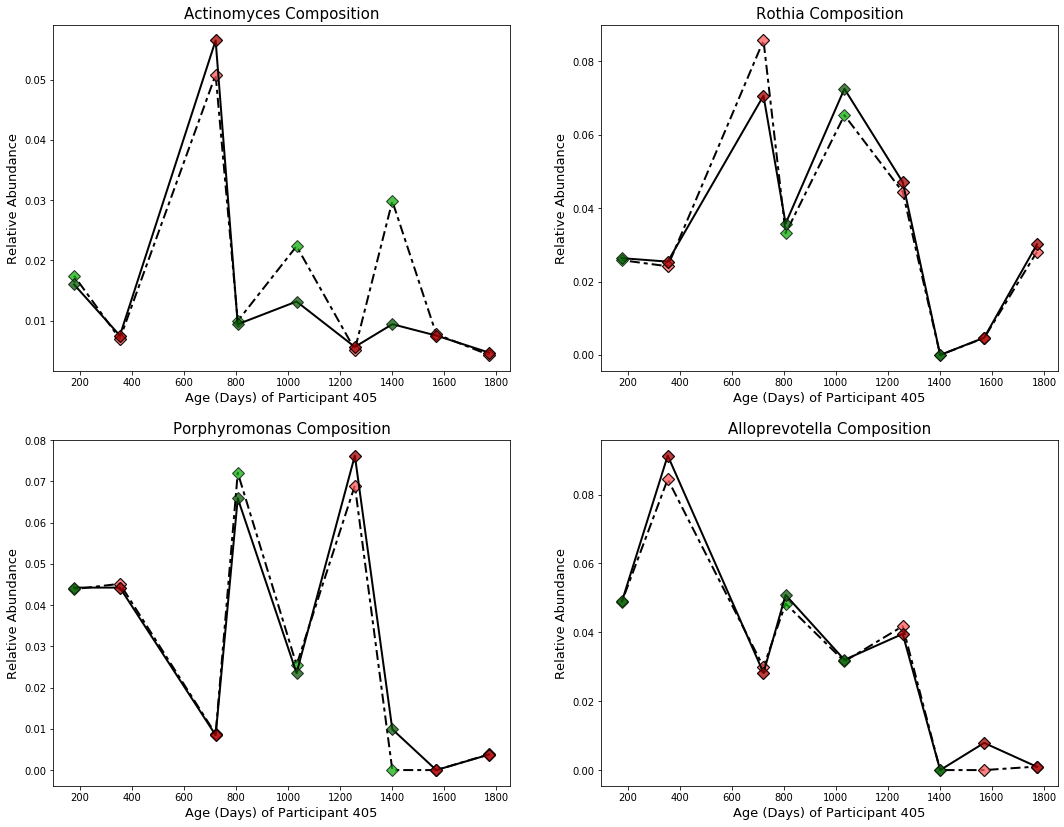

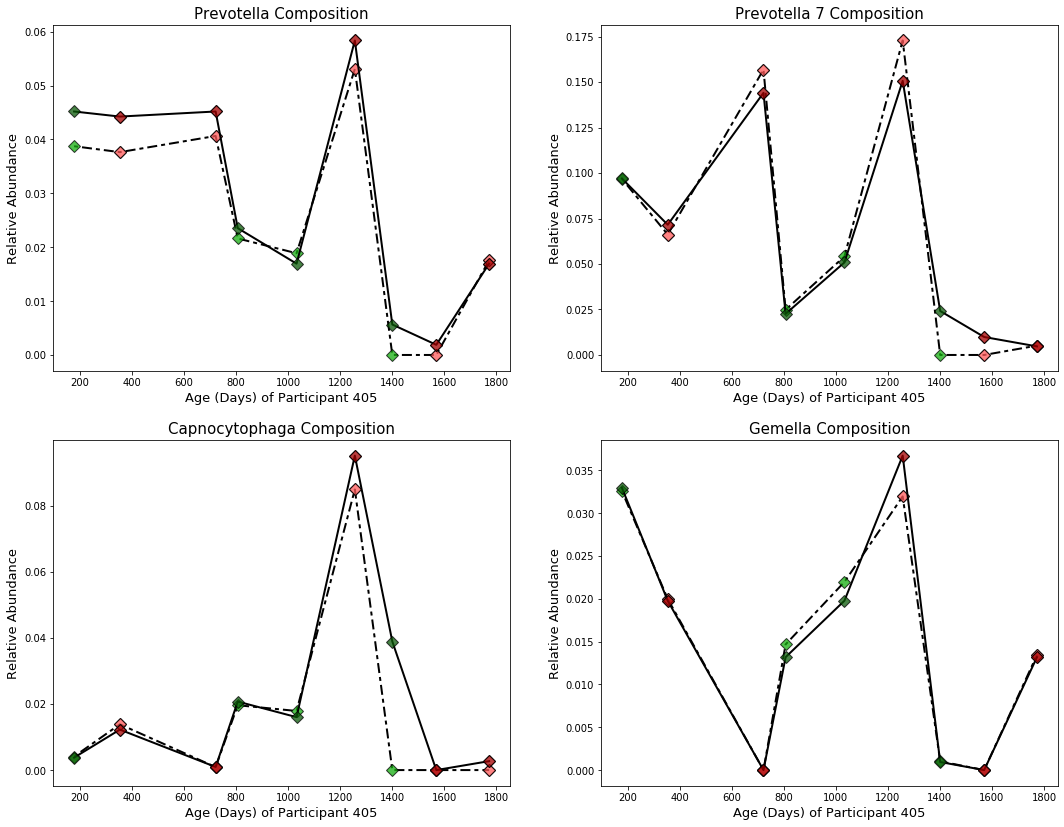

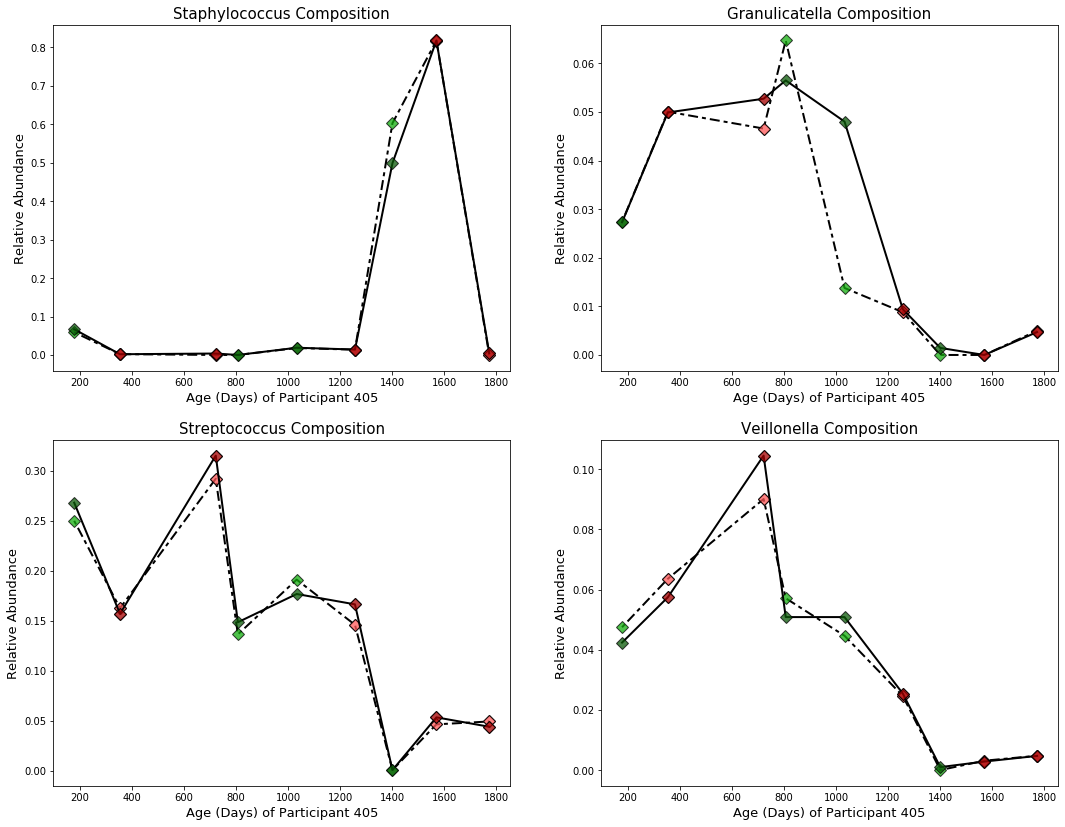

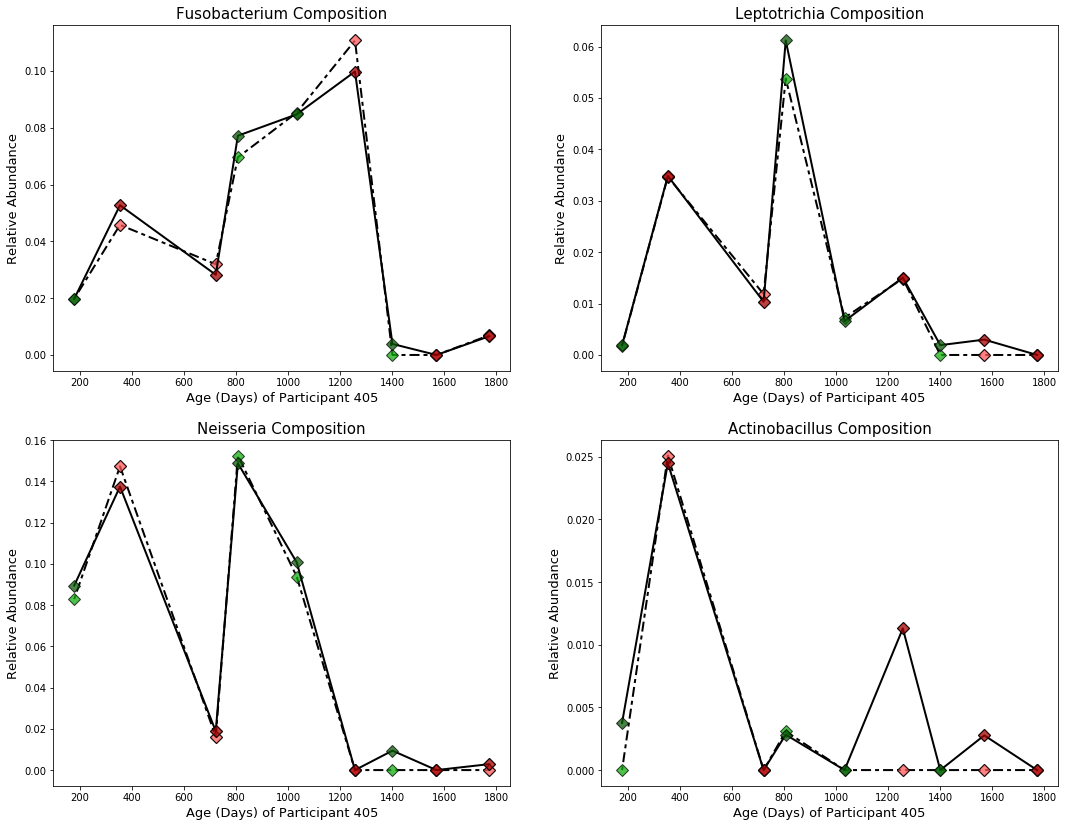

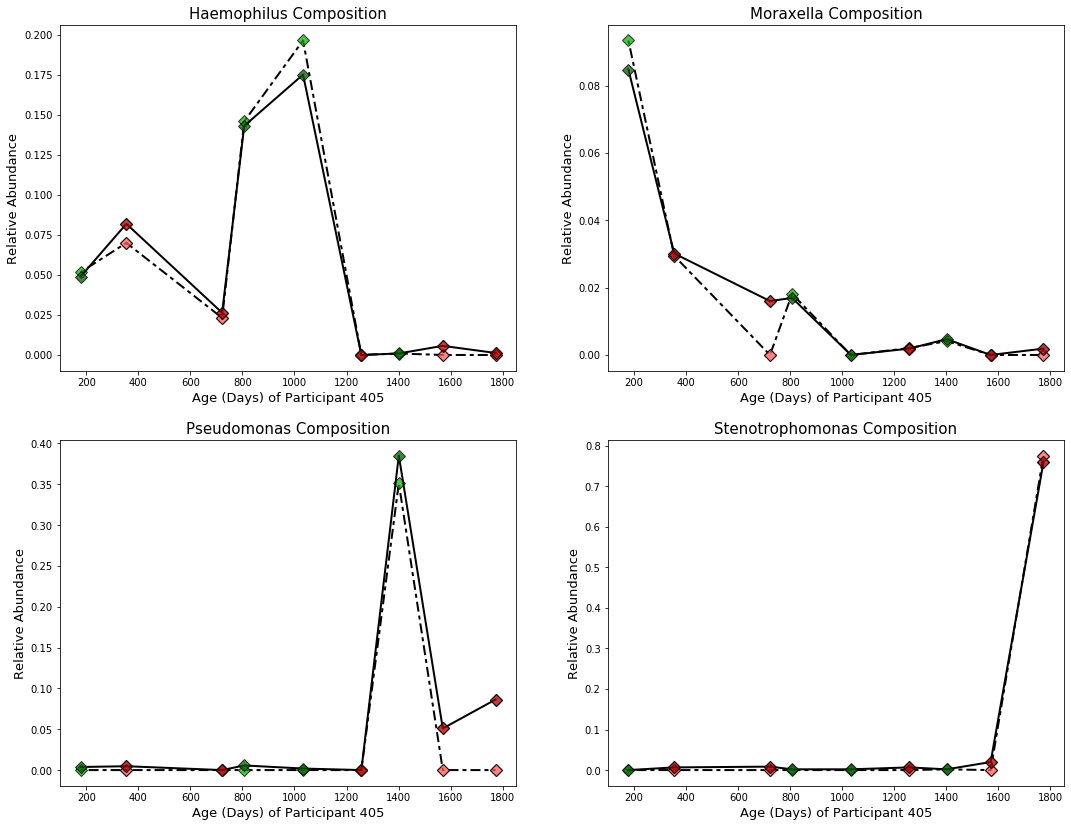

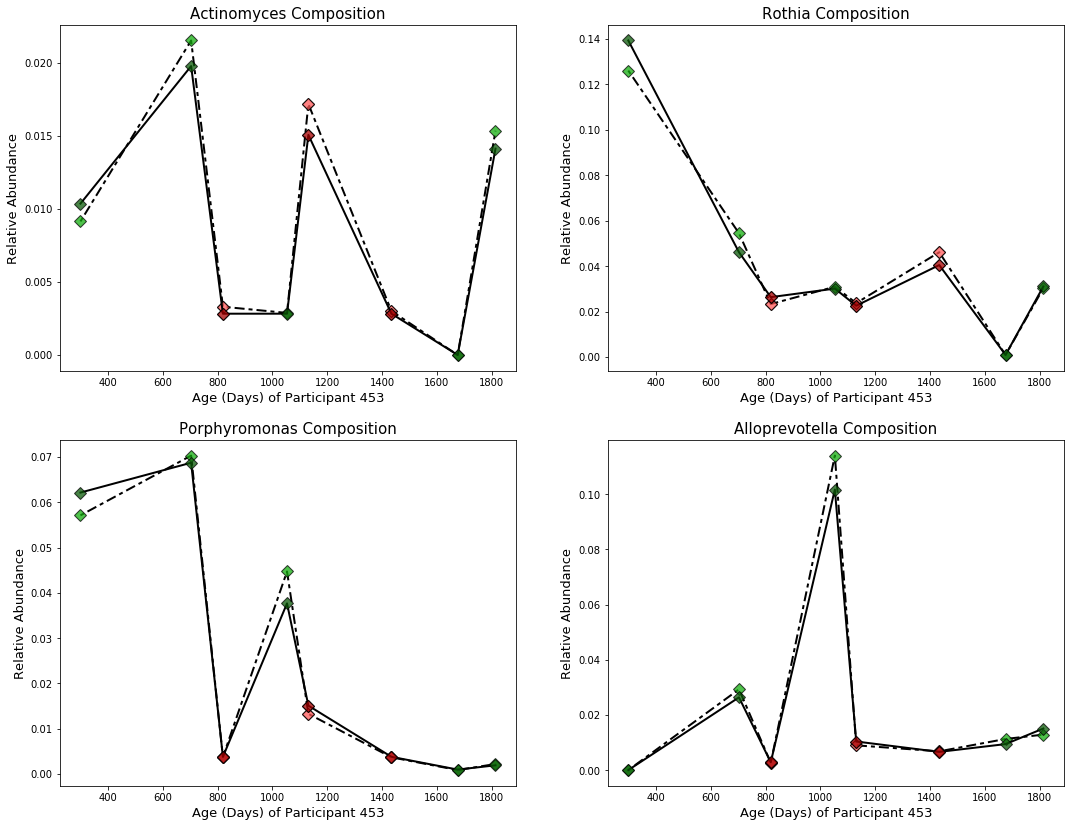

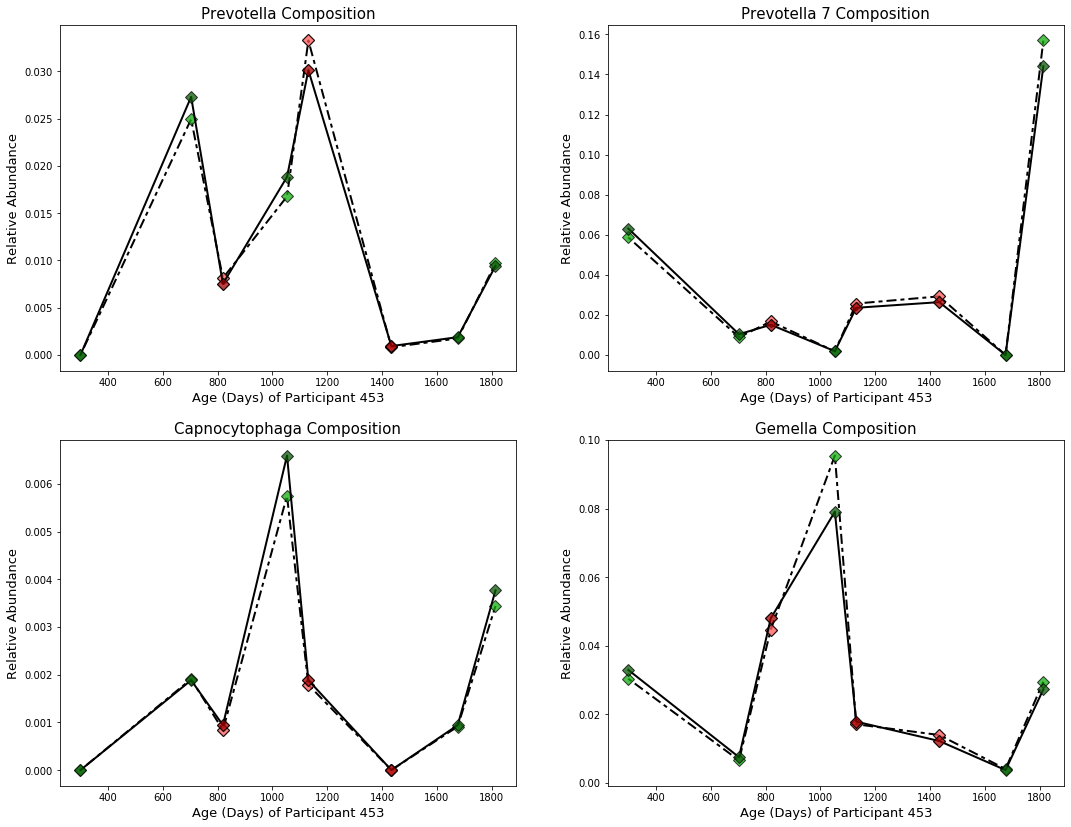

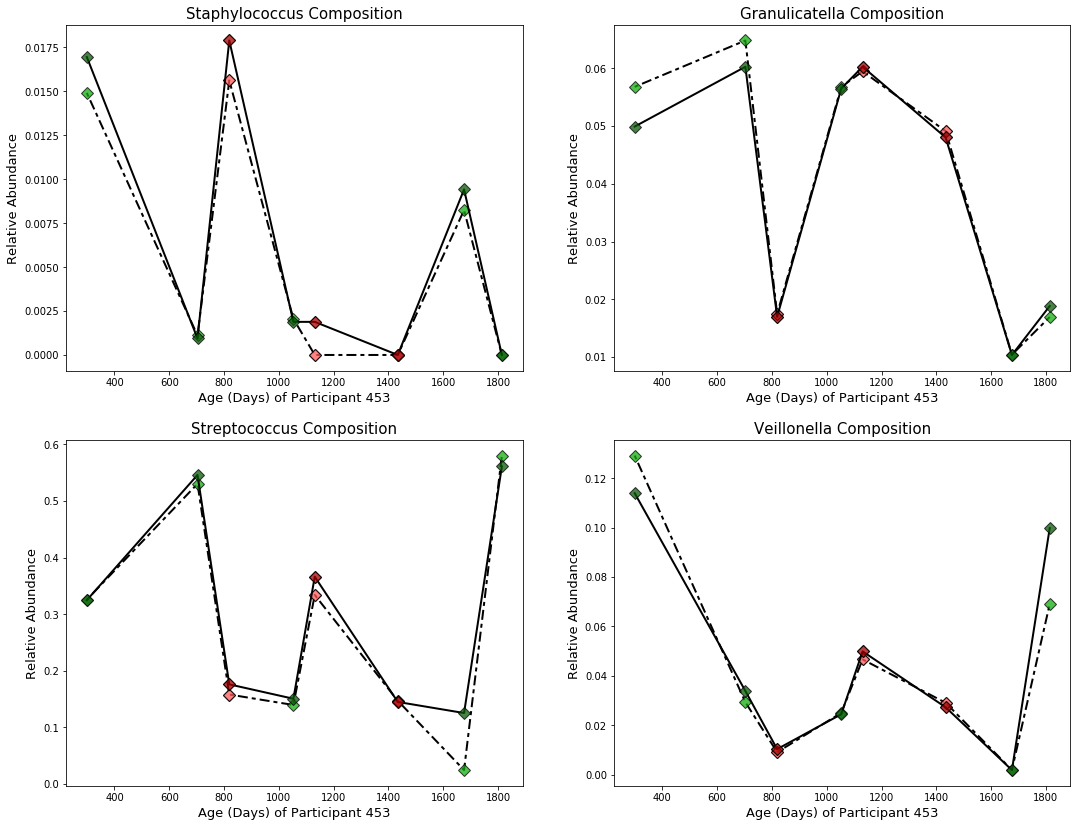

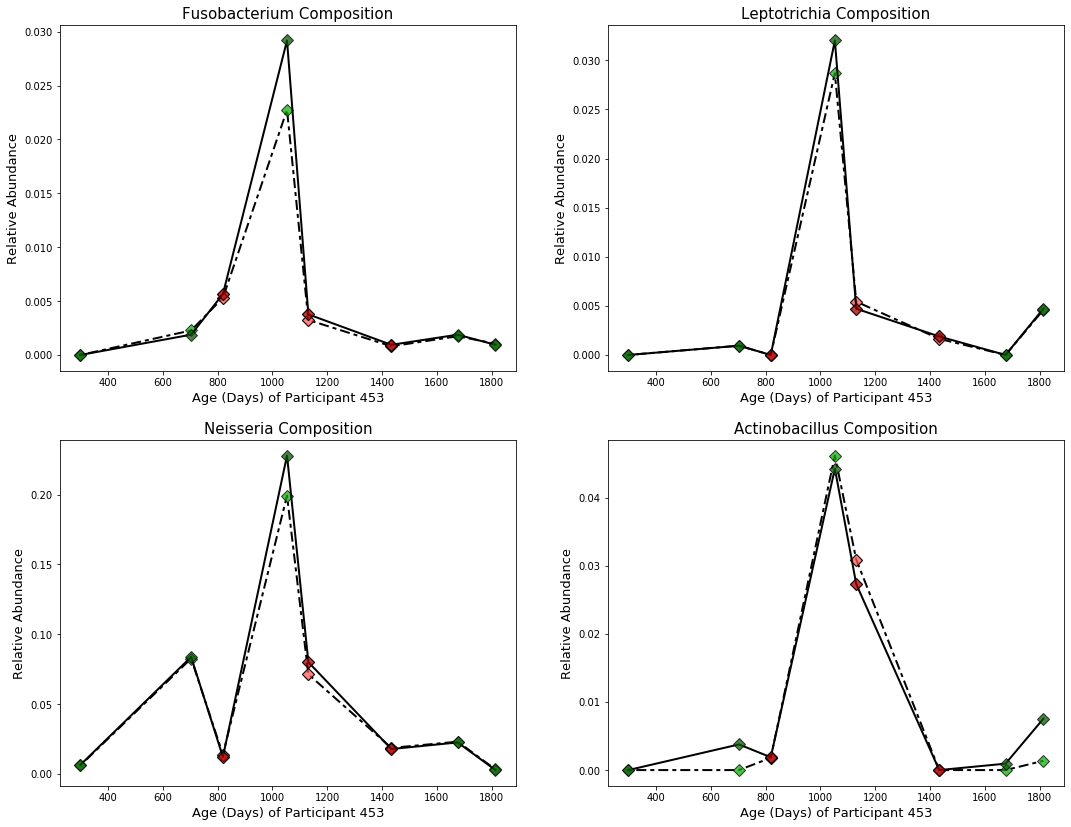

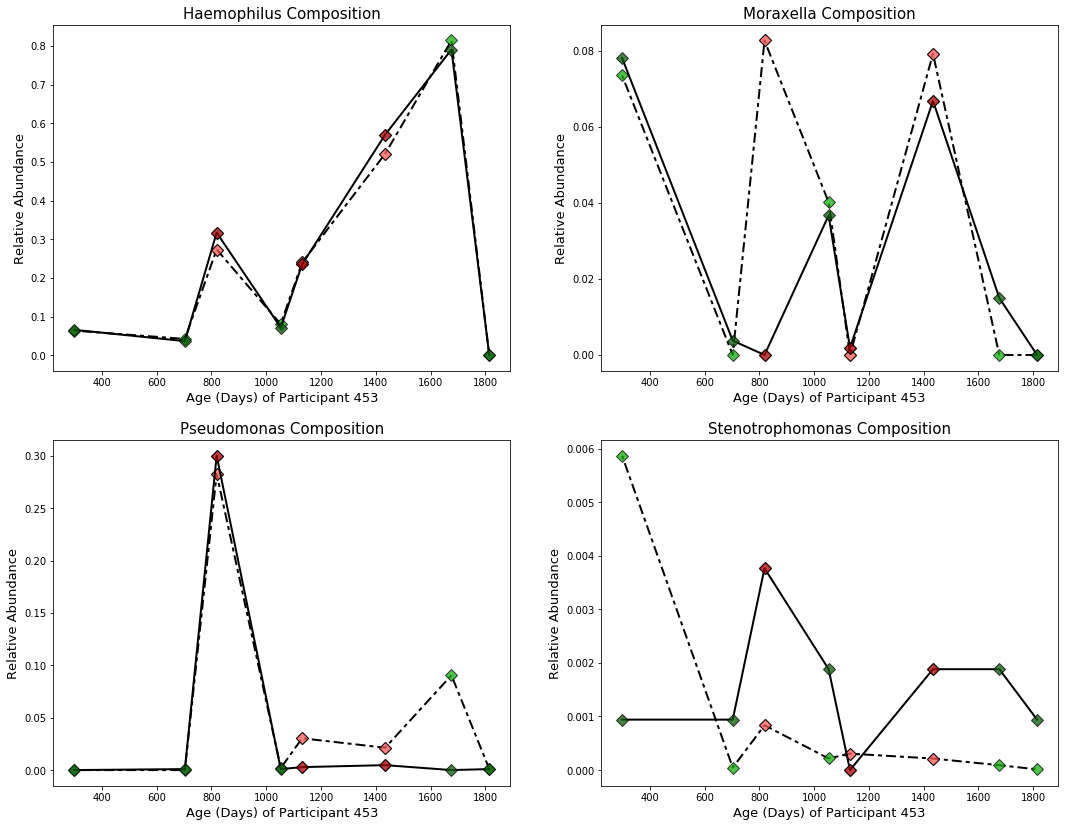

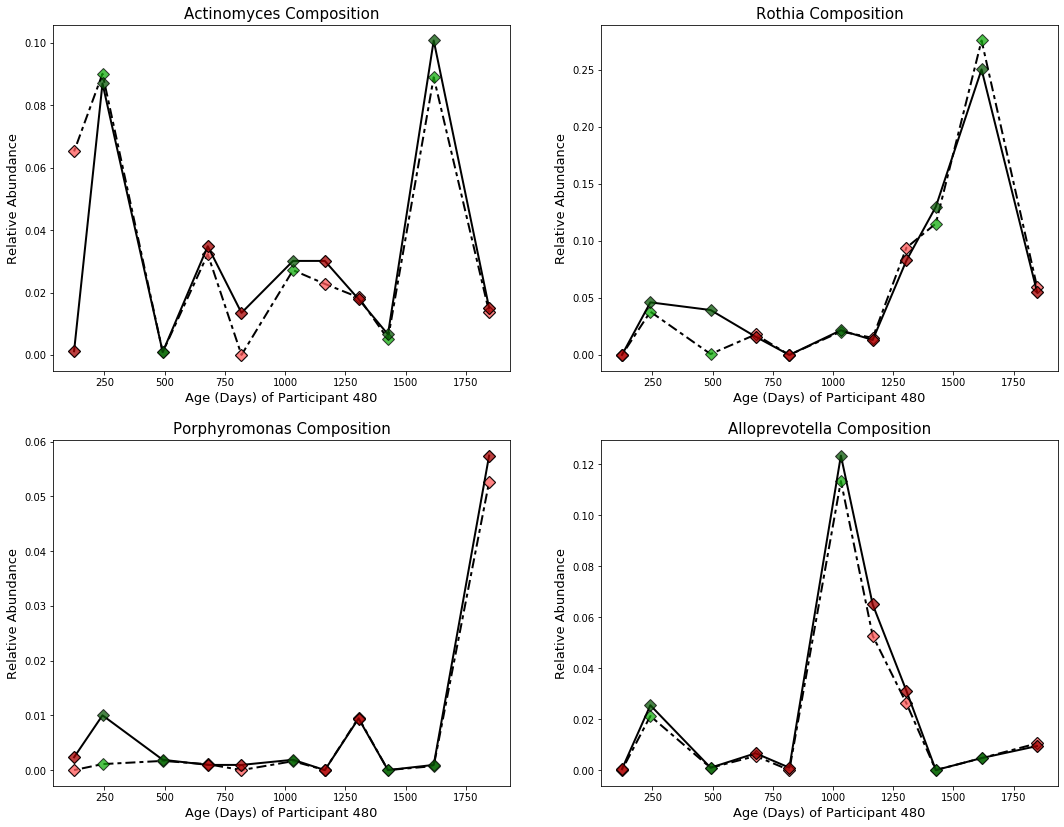

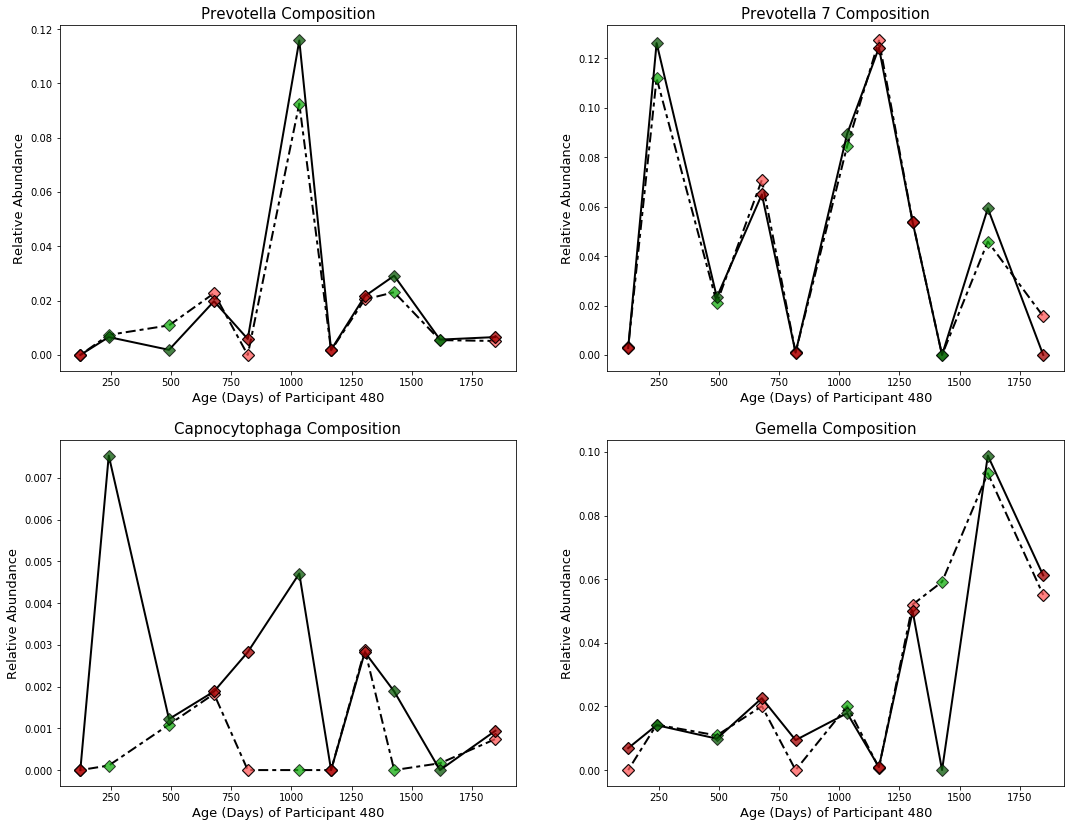

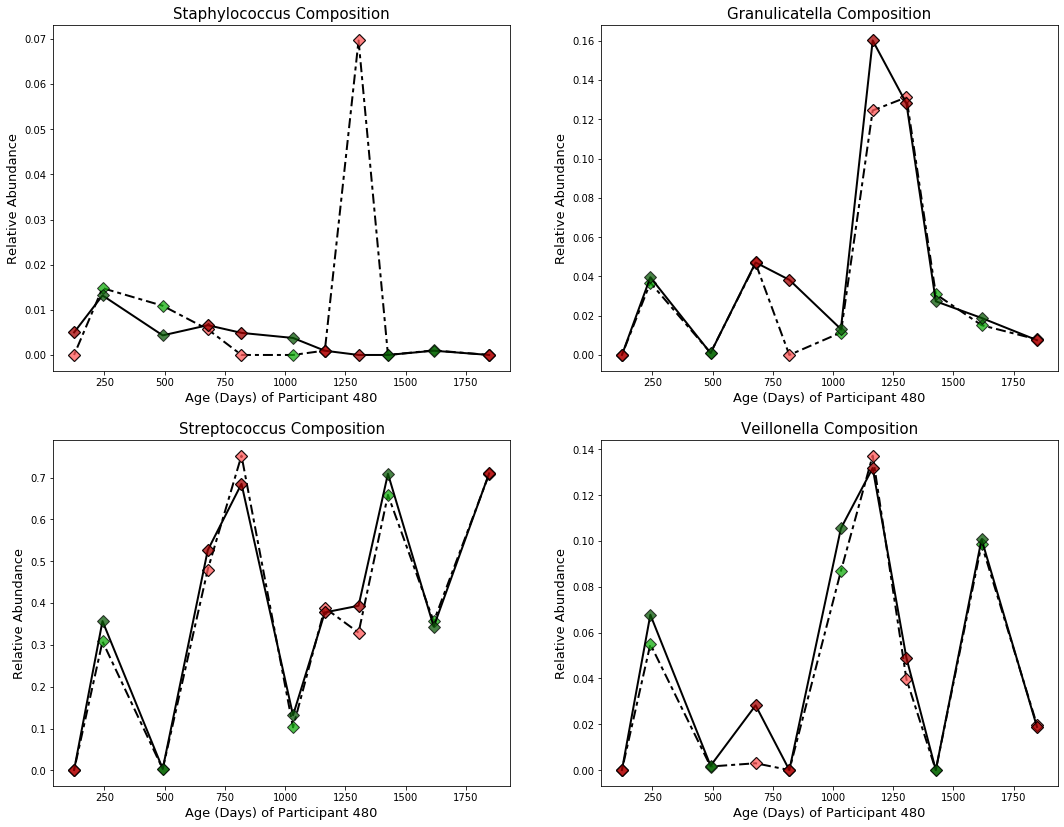

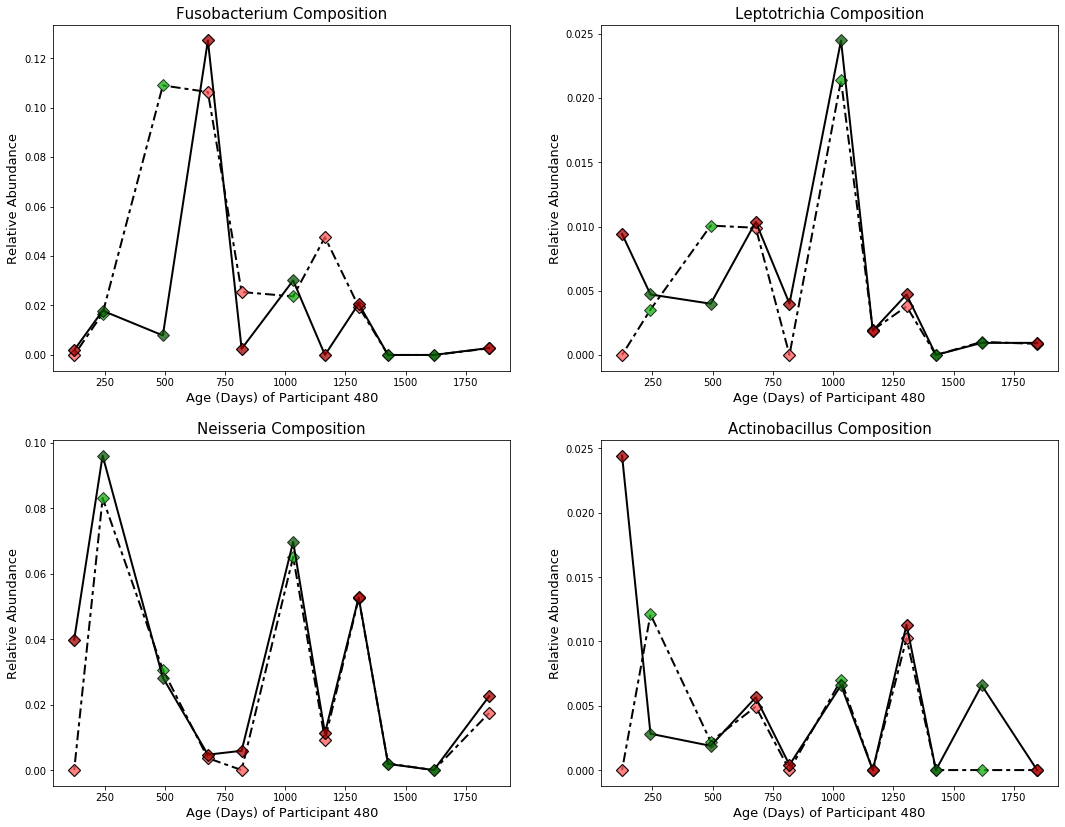

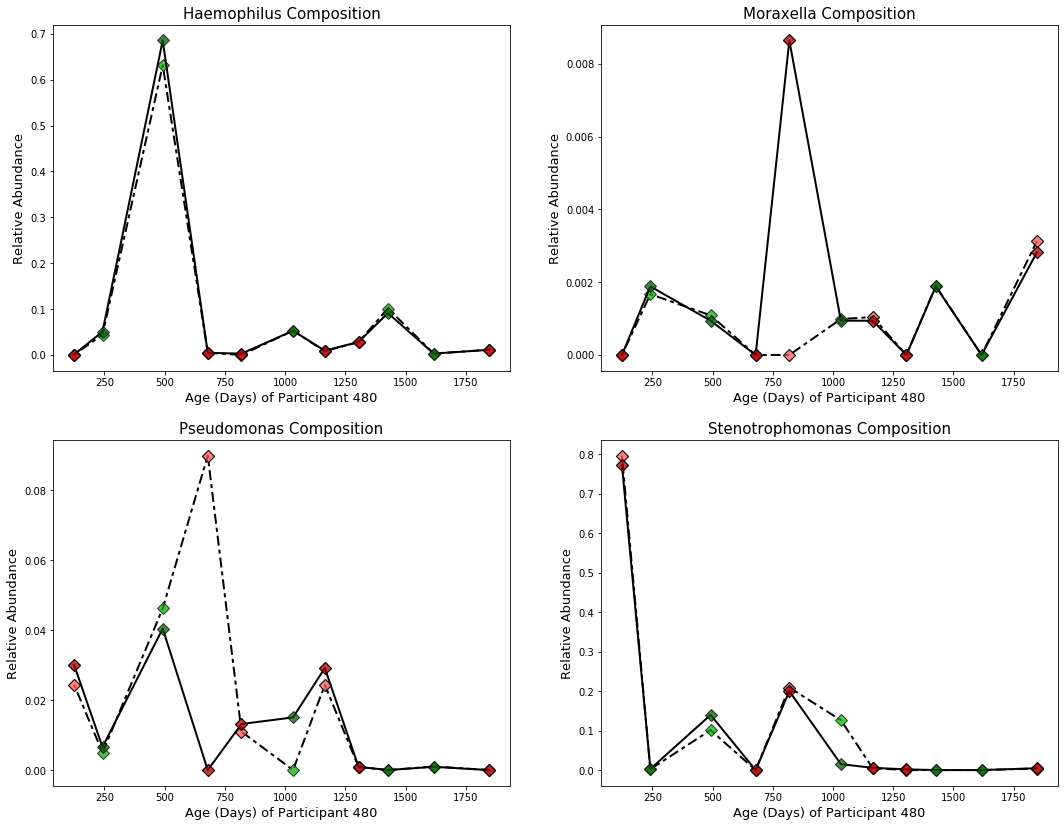

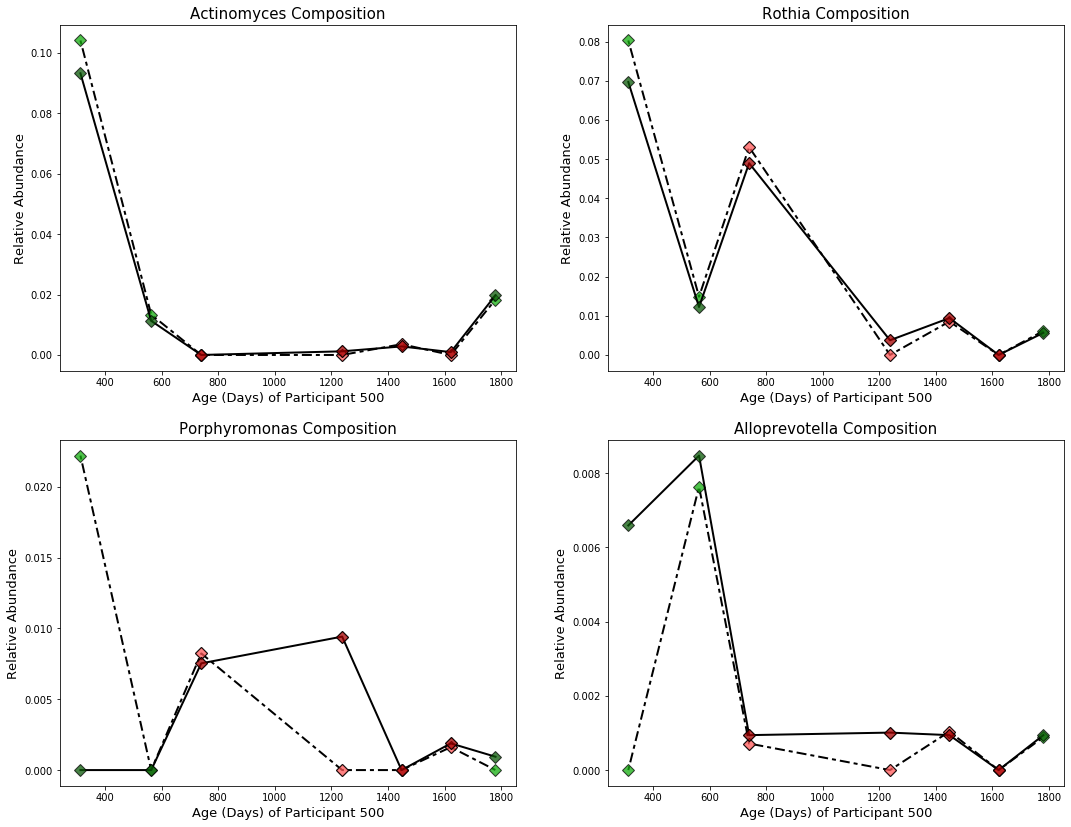

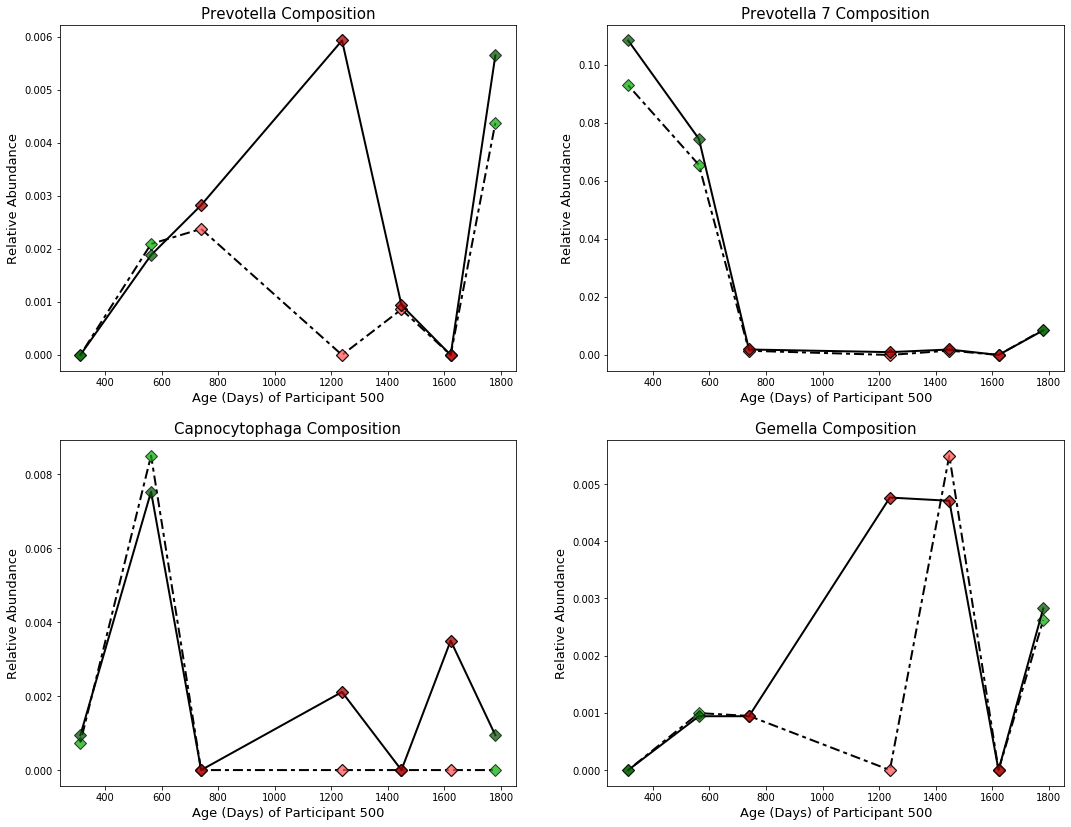

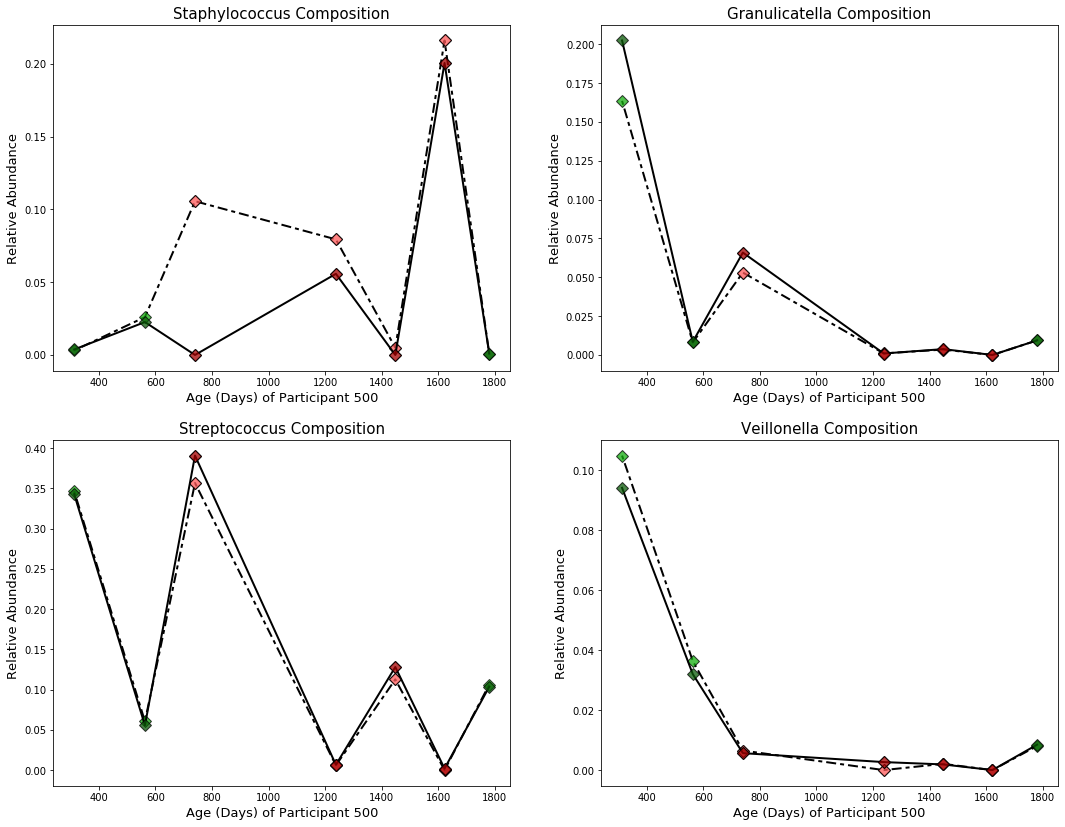

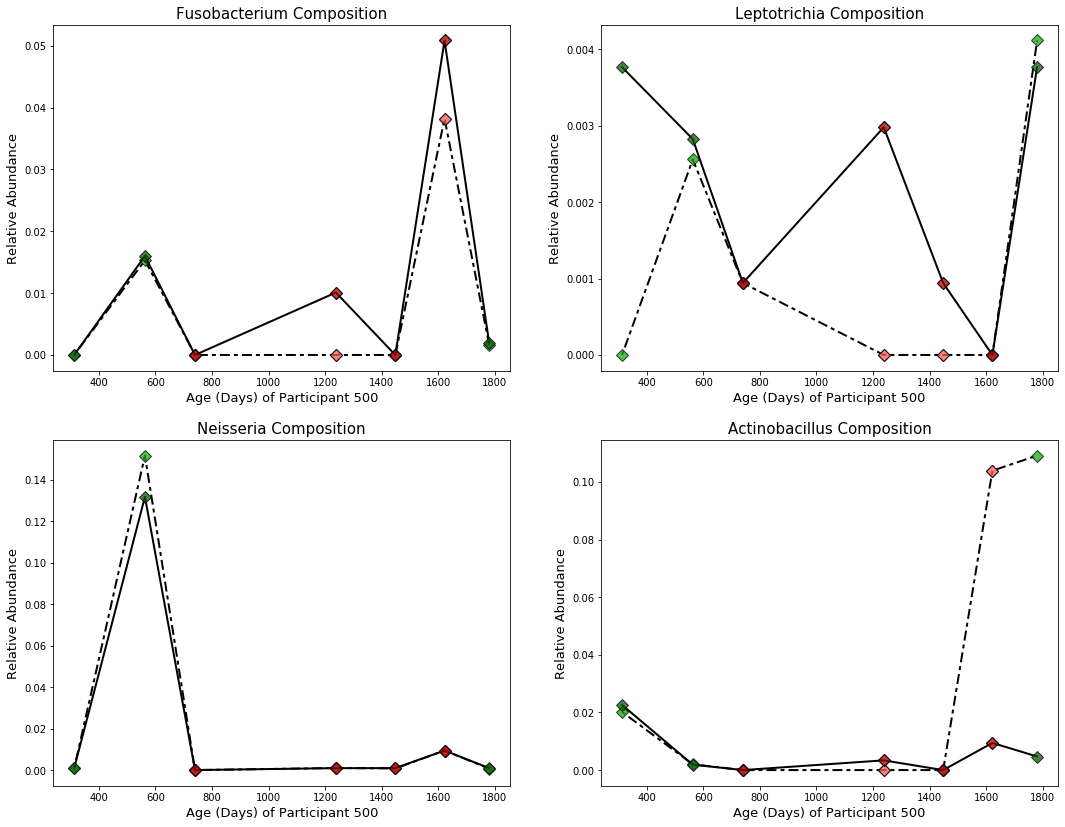

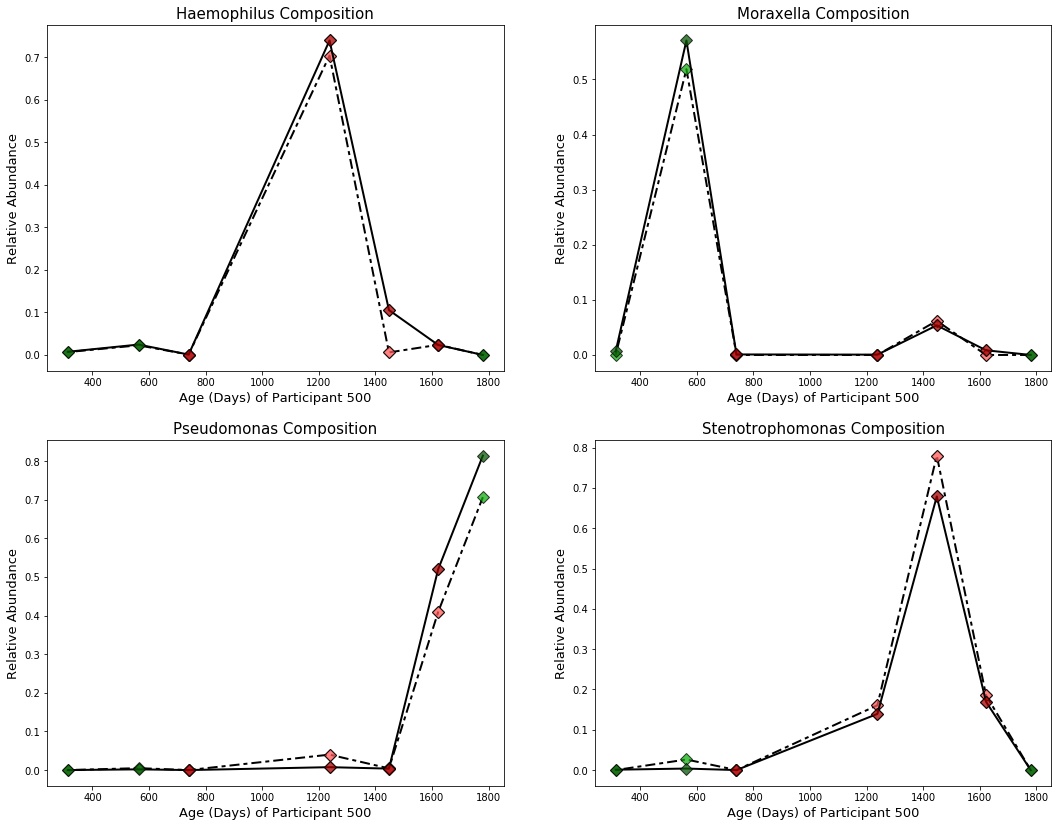

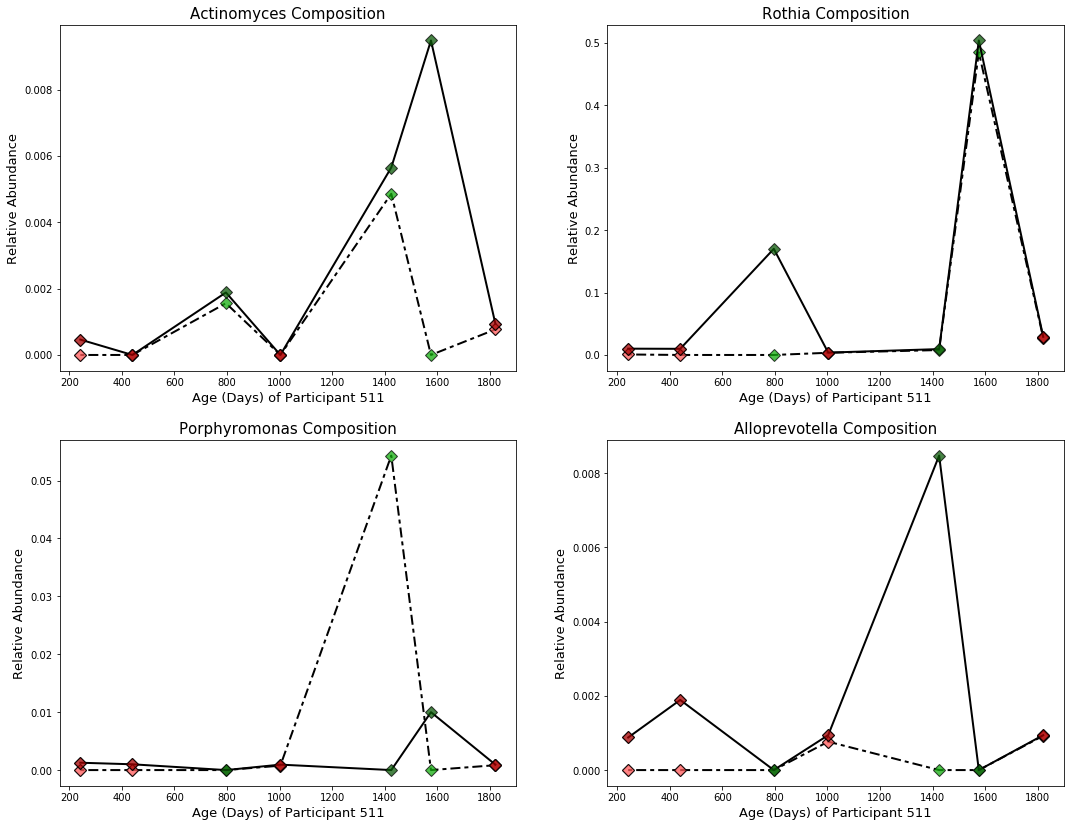

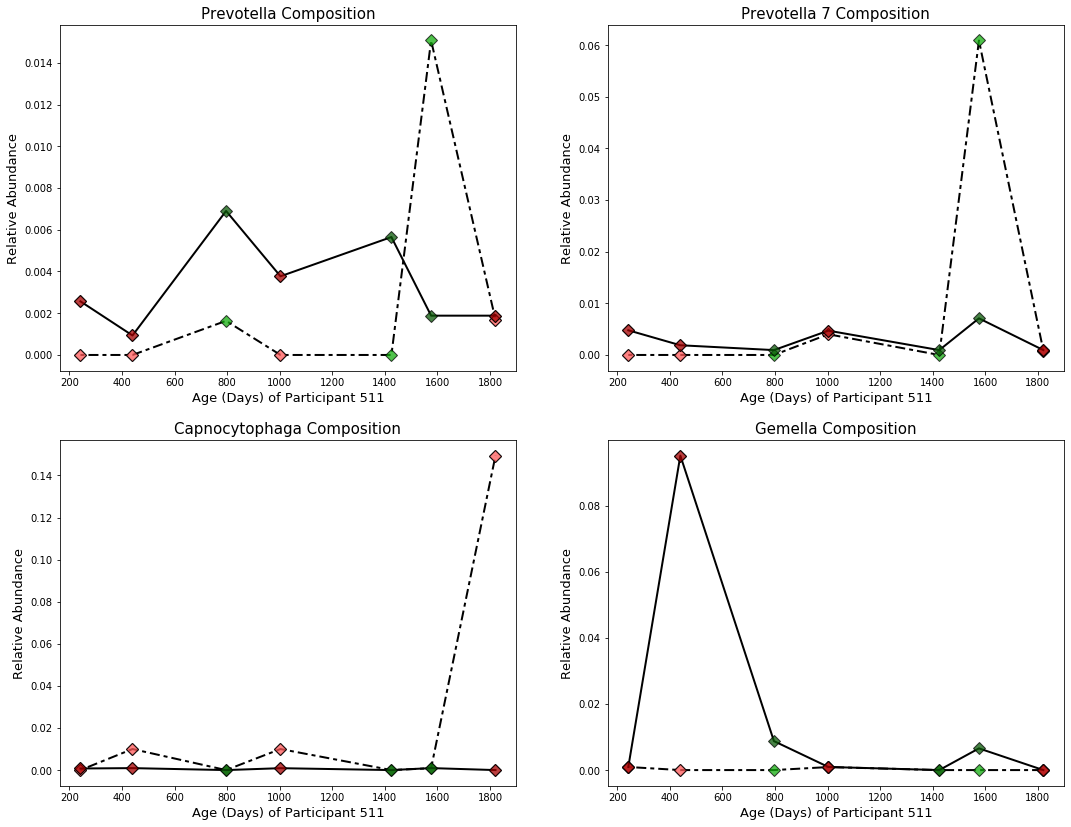

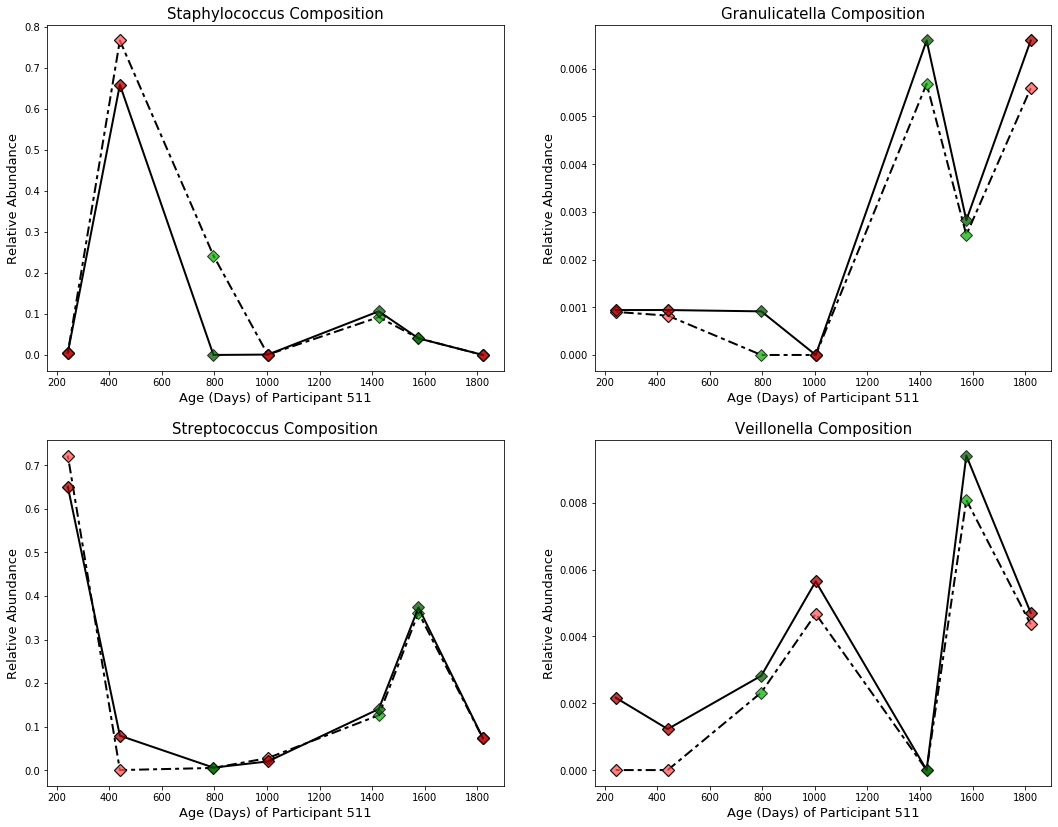

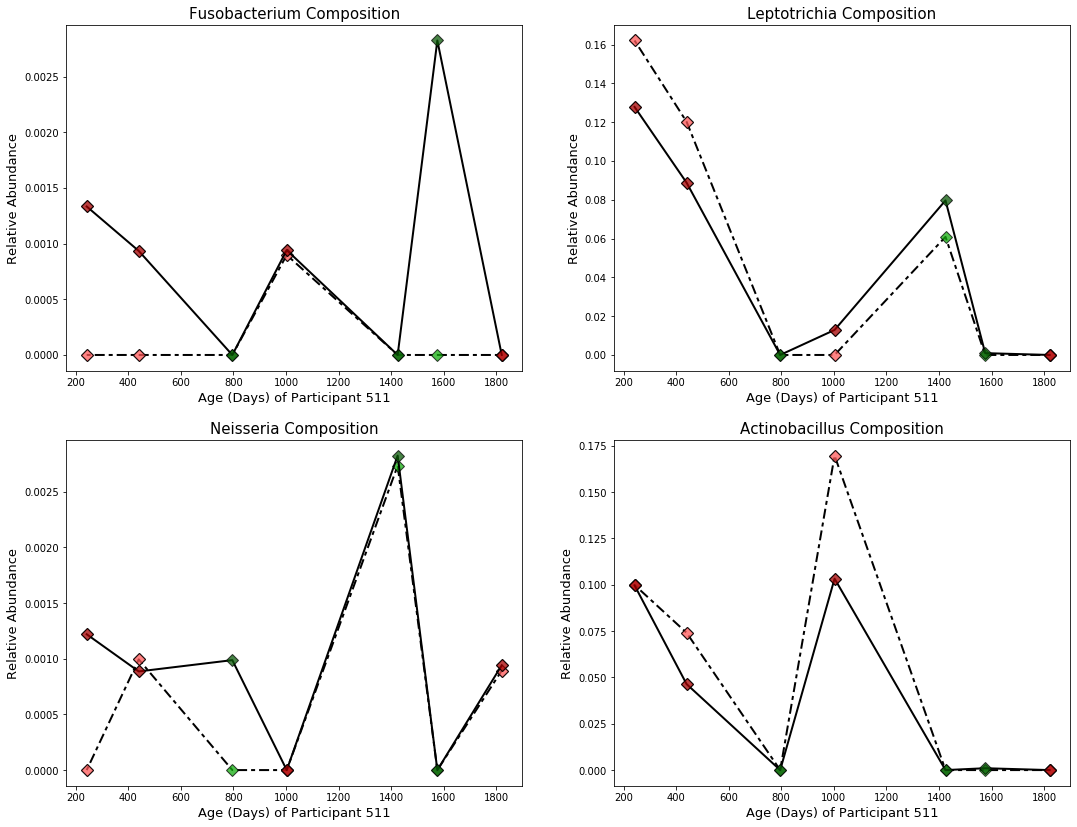

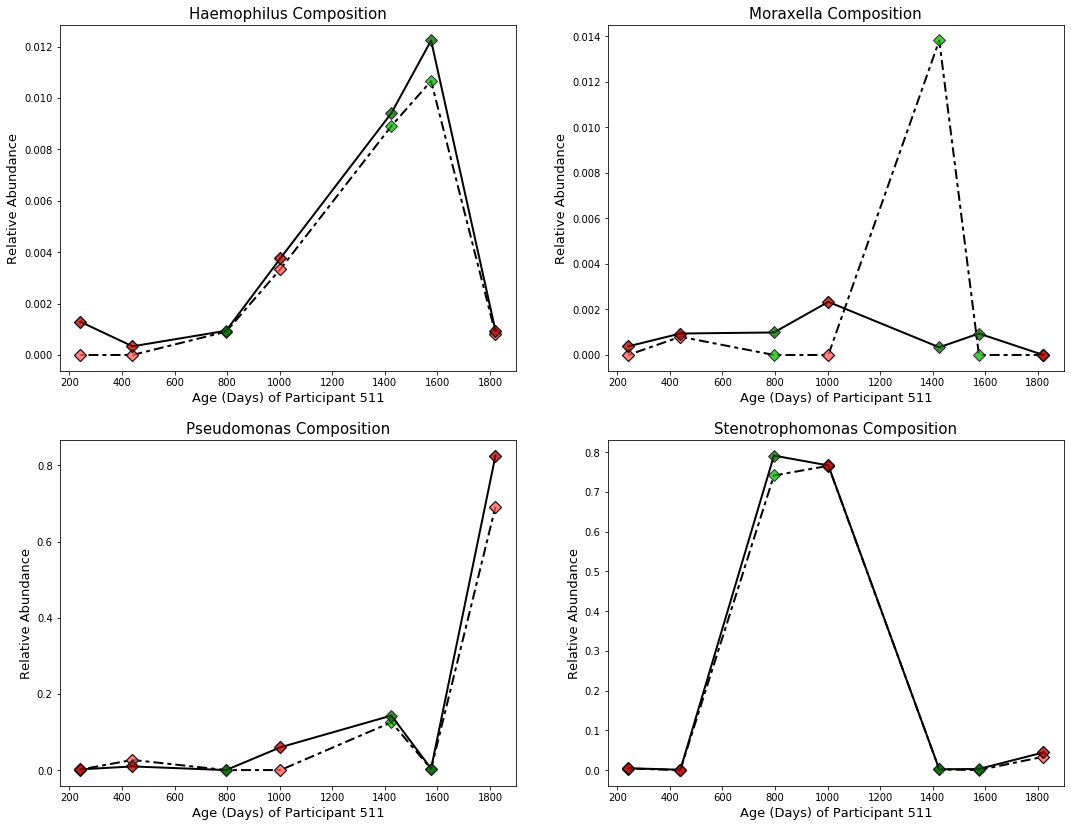

In [19]:
#run the first function in a loop
for name in IDs:
    plot_loop(name)

In [20]:
#function to plot with predictions,for use in a loop with the dictionaries
def plot_pred_loop(name):
    #divide the list of OTU's of interest into groups of 4 to facilitate plotting
    rows=[[2,30,58,59],[60,63,70,80],[94,104,113,167],[169,170,206,221],[223,227,229,234]]
    r=reordered_dfs[name]
    rel=rel_dfs[name]
    days=[int(x) for x in rel.columns]
    markers_r = markers_rdict[name]
    markers_g = markers_gdict[name]
    markers_r1 = markers_r1dict[name]
    markers_g1 = markers_g1dict[name]
    ID=int(name) 
    #run a loop to plot each group of 4 in a 2 by 2 format with our custom markers, then save the file
    for j in range(0,5):
        fig = plt.figure(figsize=(18,14))
        for i in range(0,4):
            ax = fig.add_subplot(2,2,i+1)
            #because I made my markers slightly transparent, I need separate plots for lines and red markers
            #this avoids having the line become transparent
            #slightly transparent markers make it easier to see subtle differences between the lines
            #if you opt to set alpha at the default of 1 (not transparent), you can combine the first two red plots this way:
            #ax.plot(r.loc[0]+days[0], r.iloc[rows[j][i]],'-gD', markevery=markers_r1, markerfacecolor=l_red,markersize=8, 
                    #linewidth=2,dashes=[2, 2,5,2], c='black')                
            #there is no built-in way to customise marker colours by variables, so the green markers always need a dummy line            
            ax.plot(r.loc[0]+days[0], r.iloc[rows[j][i]],'-gD', markevery=markers_r1, markerfacecolor='none',markersize=8, 
                    linewidth=2,dashes=[2, 2,5,2], c='black')
            ax.plot(r.loc[0]+days[0], r.iloc[rows[j][i]],'-gD', markevery=markers_r1, markerfacecolor=l_red, alpha=0.75, 
                    markersize=8, c='none')
            ax.plot(r.loc[0]+days[0], r.iloc[rows[j][i]],'-gD', markevery=markers_g1, markerfacecolor=l_green,alpha=0.75,
                    markersize=8, c='none')
            #again, if you prefer alpha=1 you can combine the two lines for red markers:
            #ax.plot(days,rel.iloc[rows[j][i]-1],'-gD', markevery=markers_r,markerfacecolor=d_red, markersize=8, 
                    #linewidth=2, c='black')
            ax.plot(days, rel.iloc[rows[j][i]-1],'-gD', markevery=markers_r,markerfacecolor='none',markersize=8, 
                    linewidth=2, c='black')
            ax.plot(days, rel.iloc[rows[j][i]-1],'-gD', markevery=markers_r,markerfacecolor=d_red, alpha=0.75, markersize=8, 
                    c='none')
            ax.plot(days,rel.iloc[rows[j][i]-1],'-gD', markevery=markers_g,markerfacecolor=d_green,alpha=0.75, markersize=8, 
                    c='none')
            #optional: insert code from Section 6 to add a legend for each plot - you'll probably need to adjust it if you do
            plt.title('{} Composition with Predictions'.format(key['Name'][rows[j][i]-1]), size=15)
            plt.xlabel("Age (Days) of Participant {}".format(ID), size=13)
            plt.ylabel("Relative Abundance", size=13)
            plt.savefig(r"F:\CF\Data\GPMicrobiome Data\{}_pred_{}.png".format(ID,j), format='png')
        plt.show()

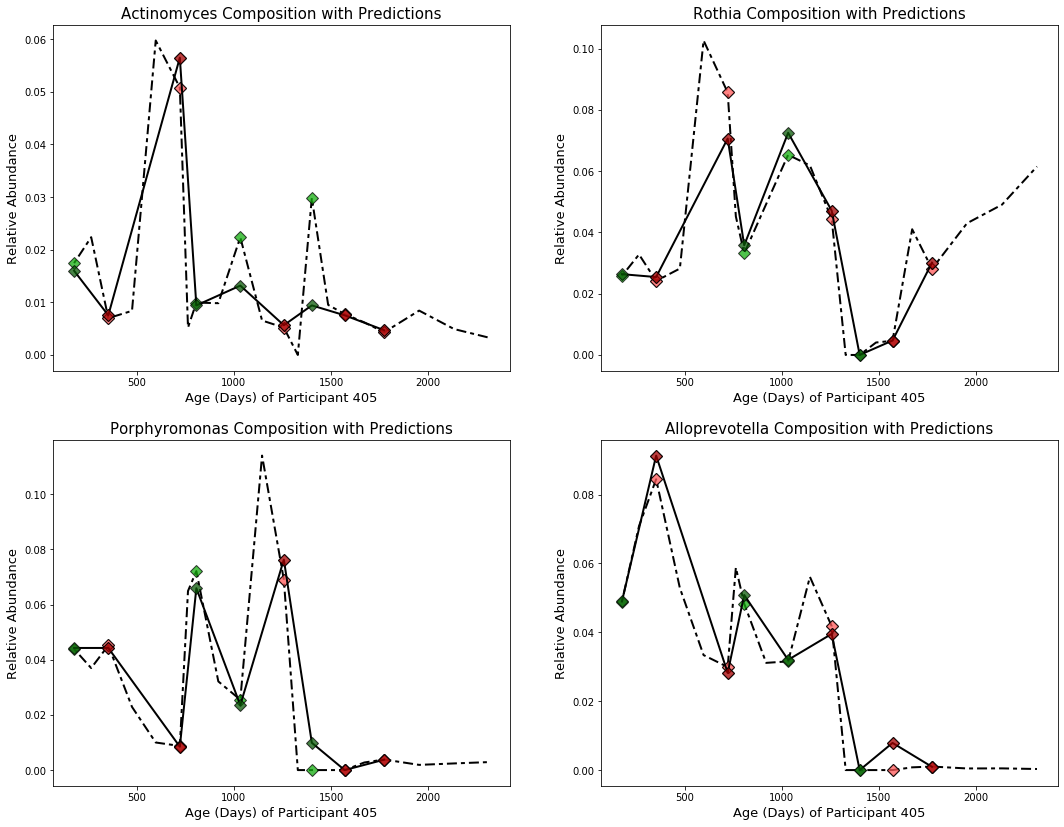

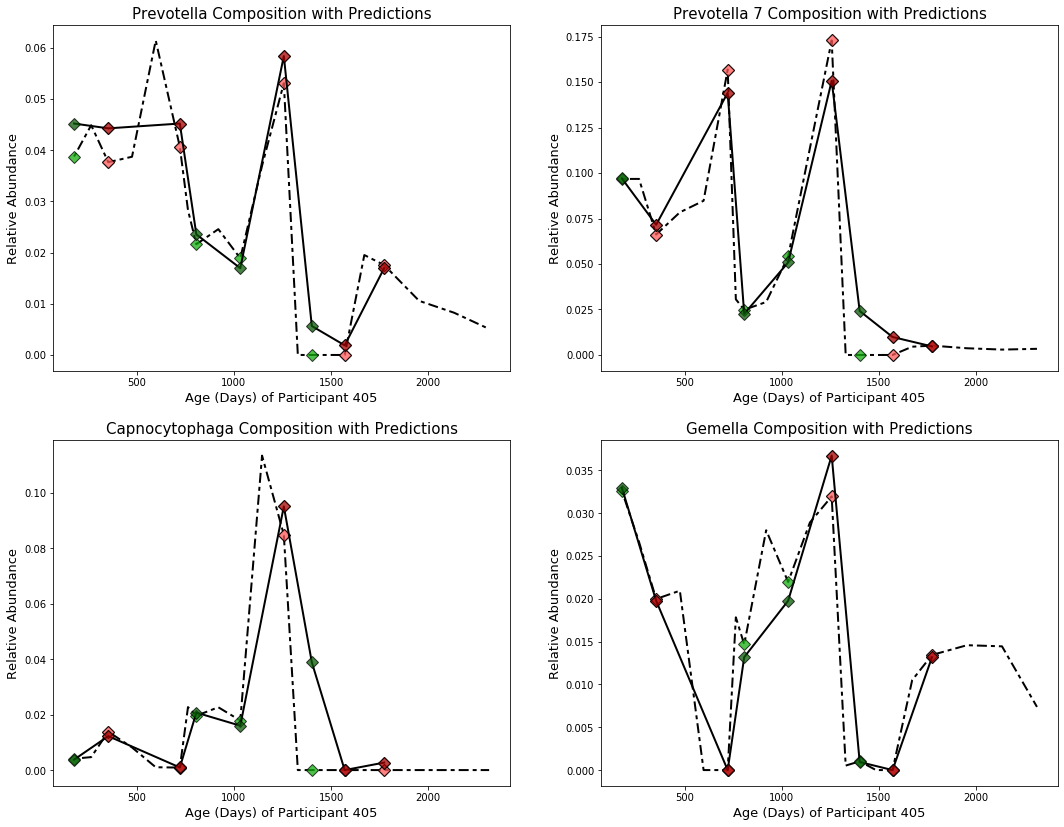

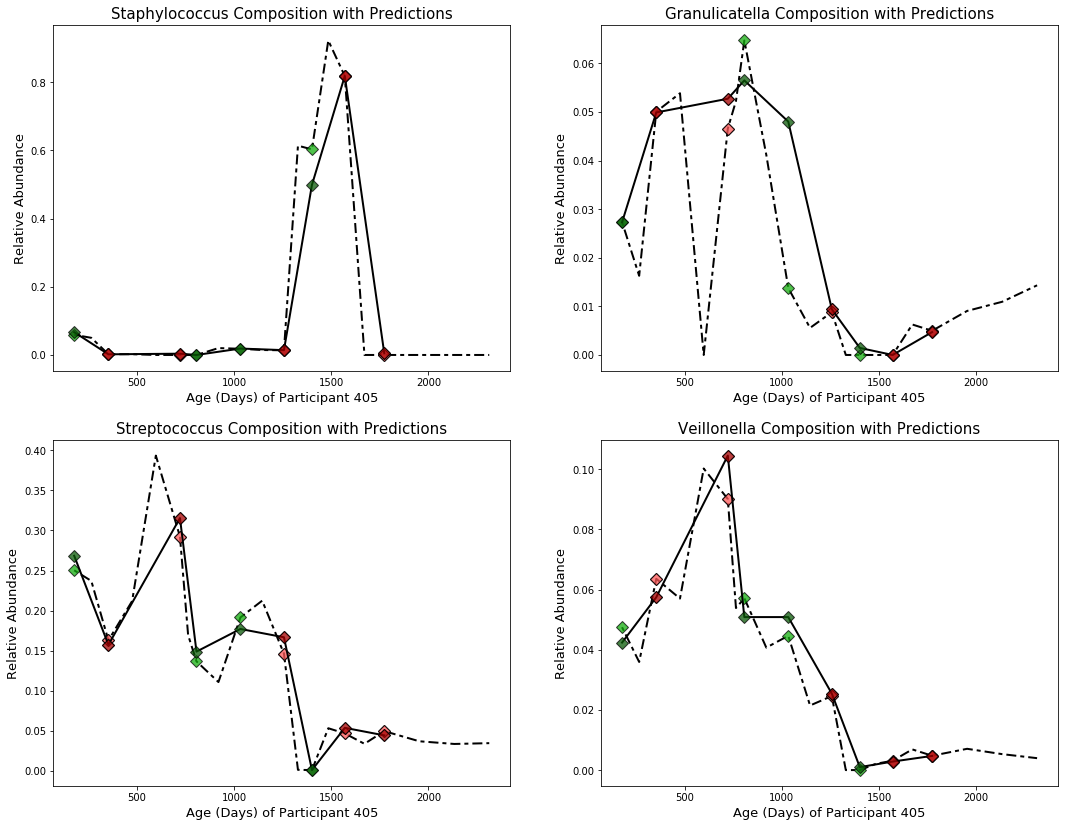

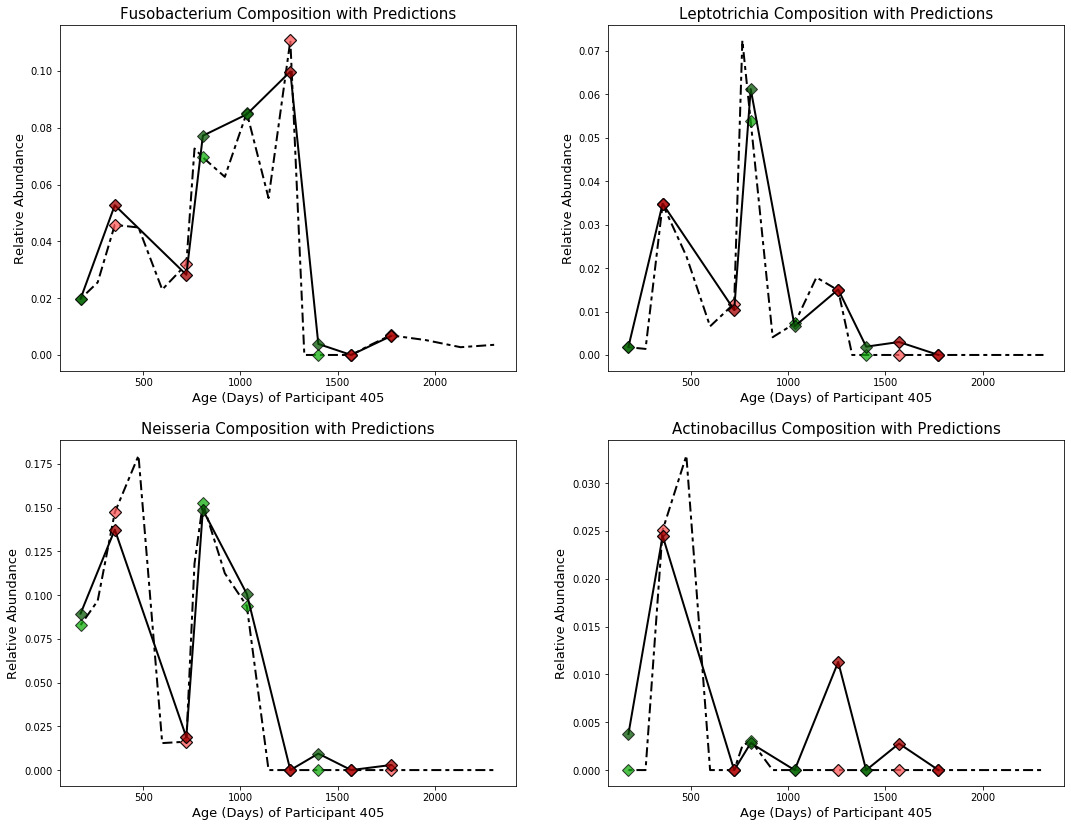

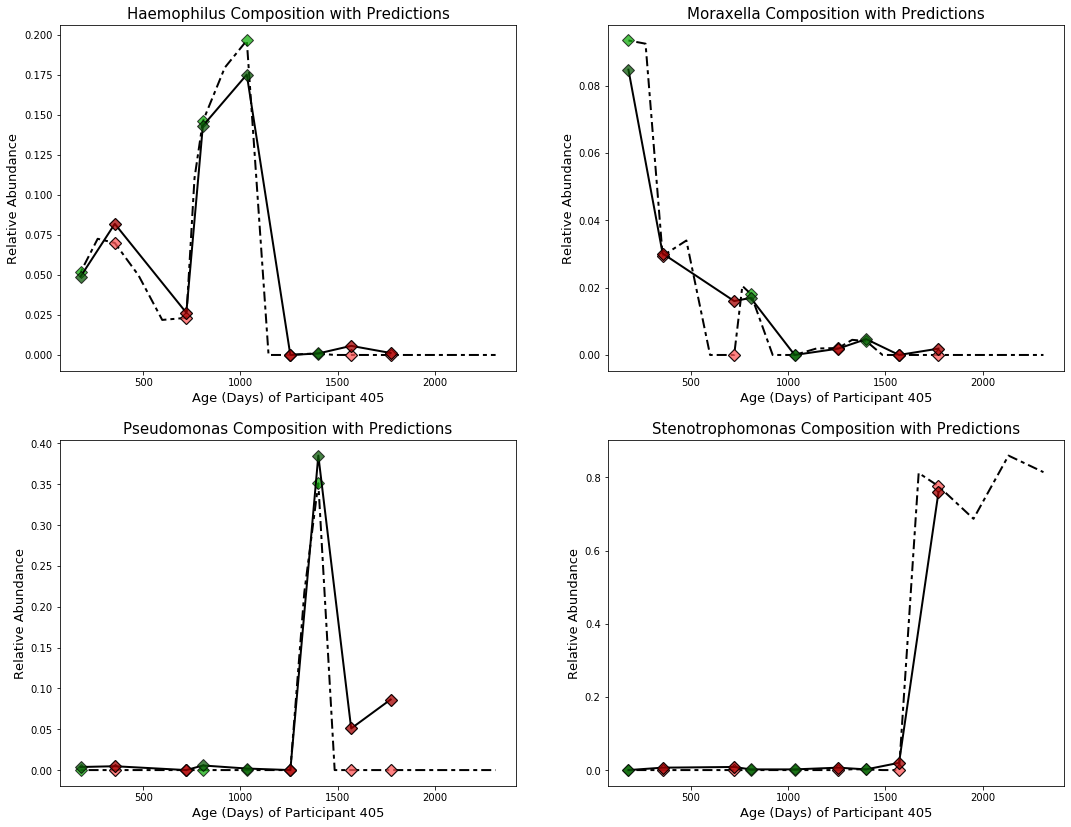

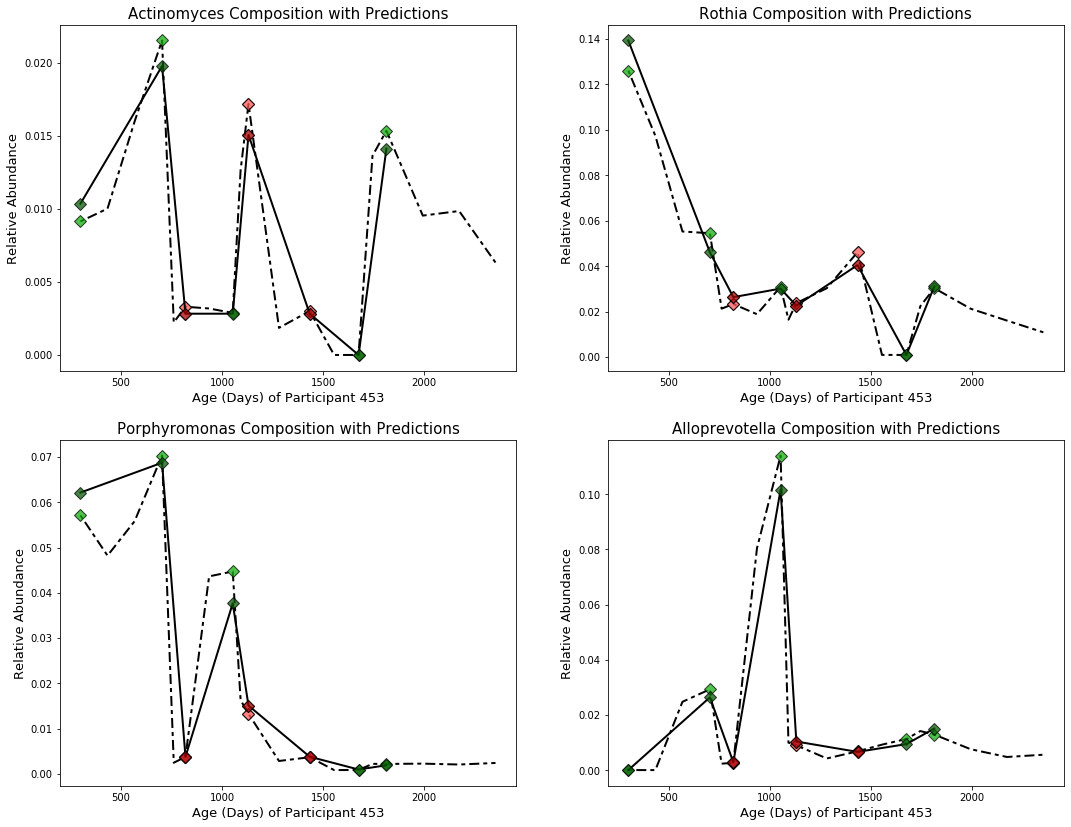

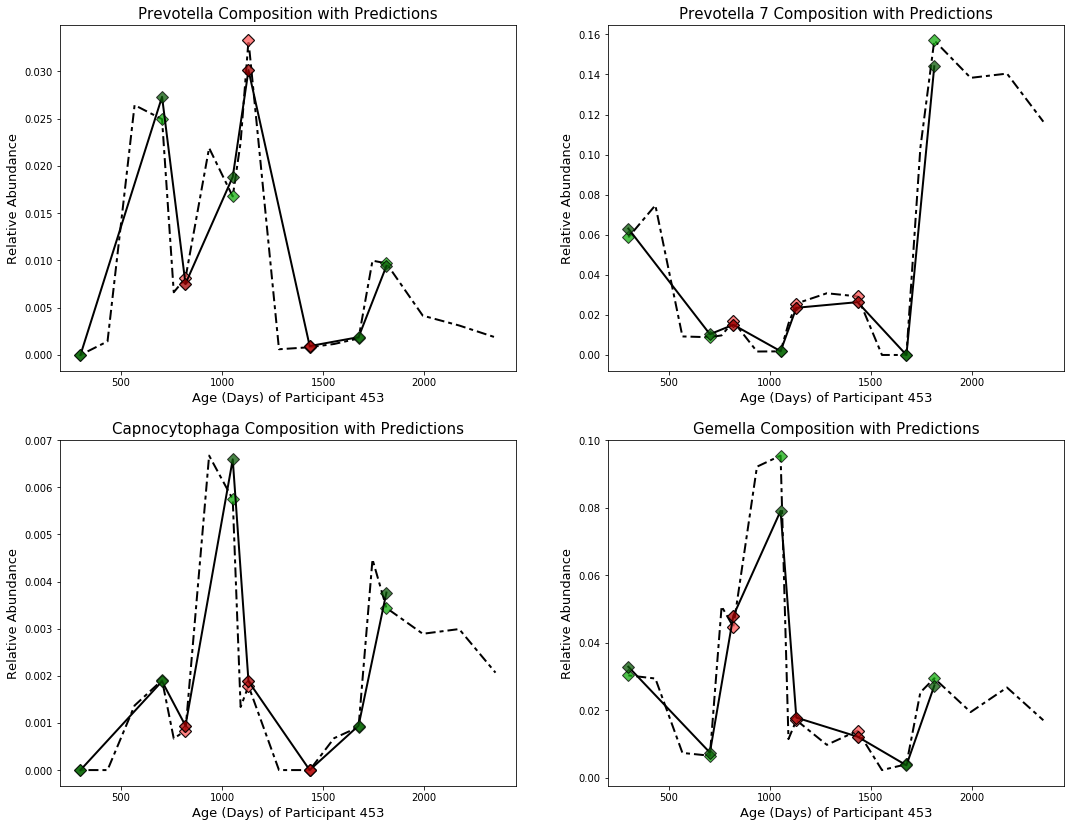

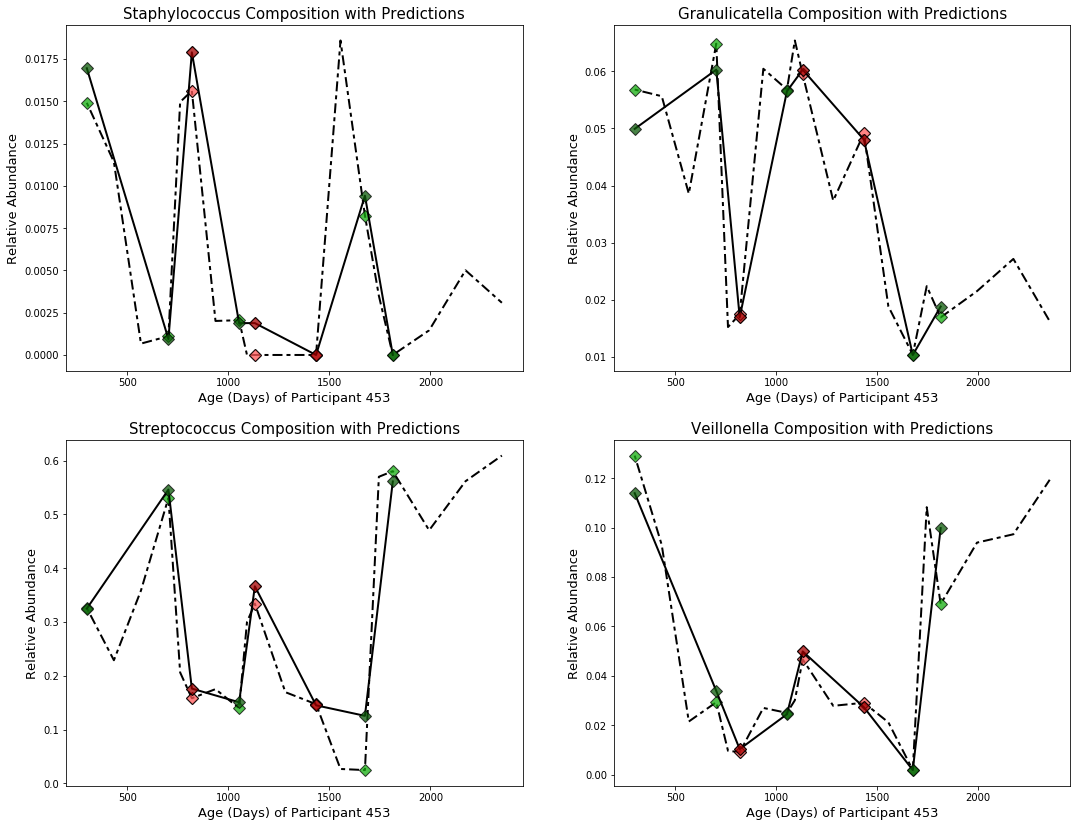

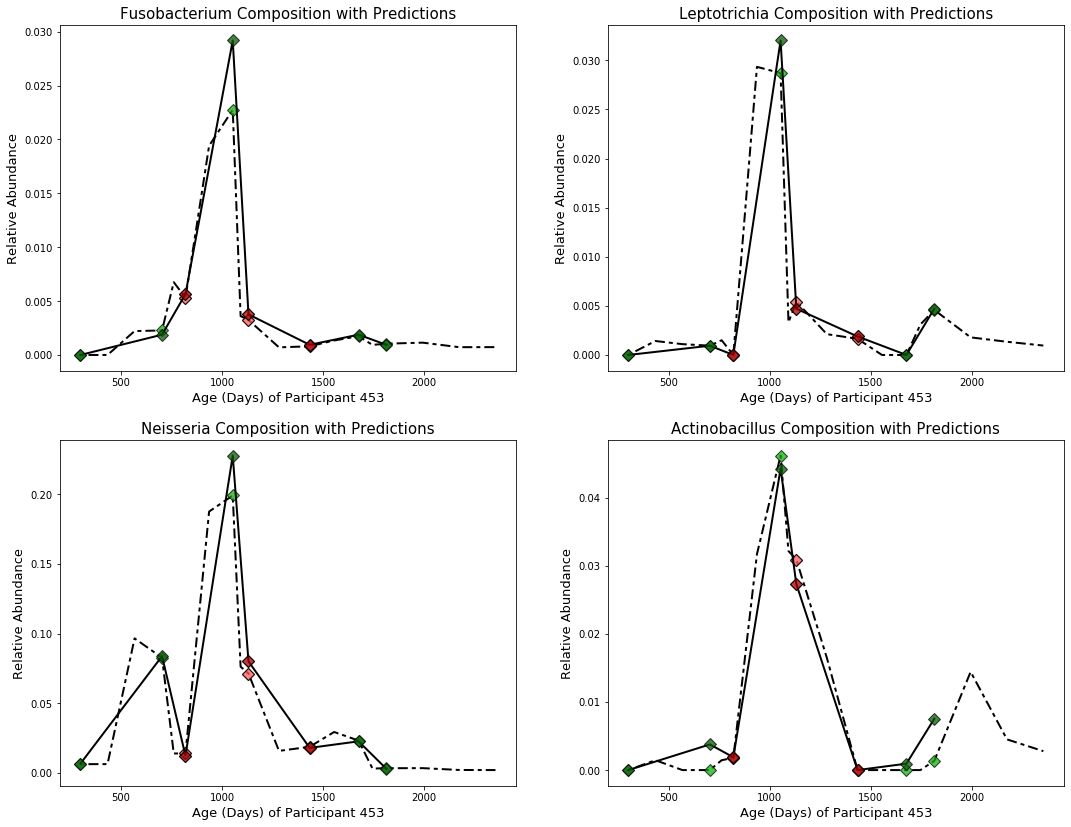

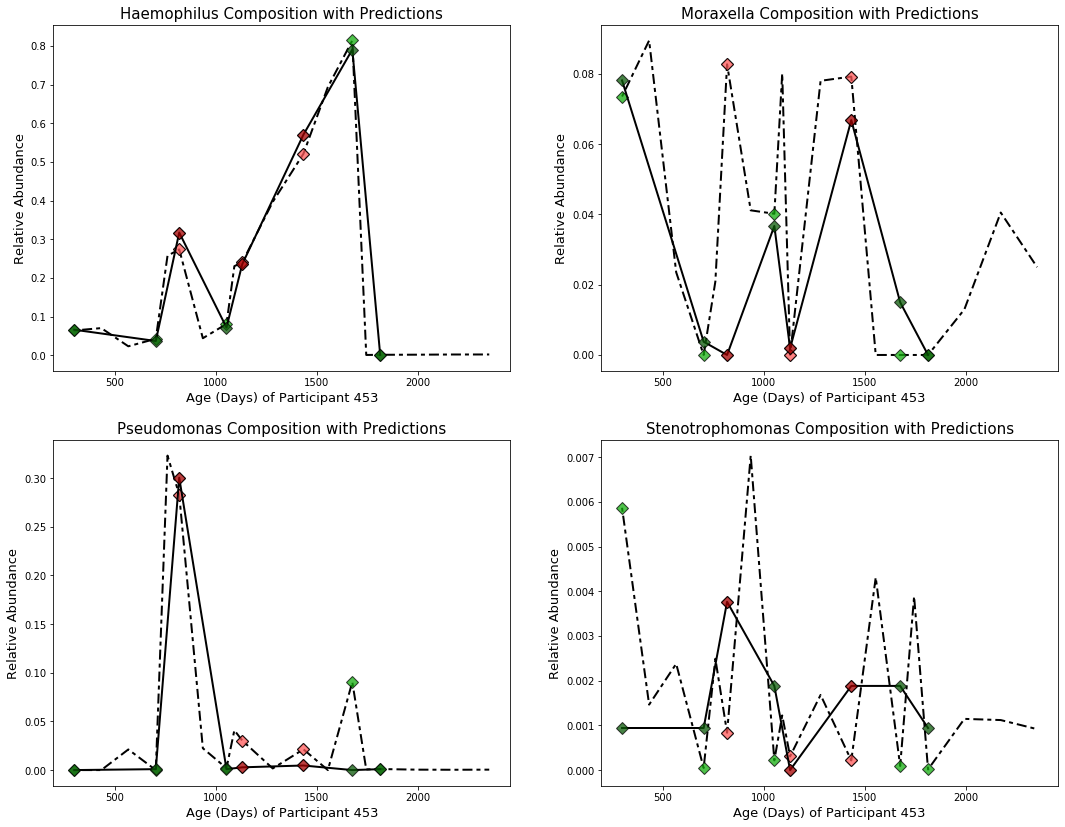

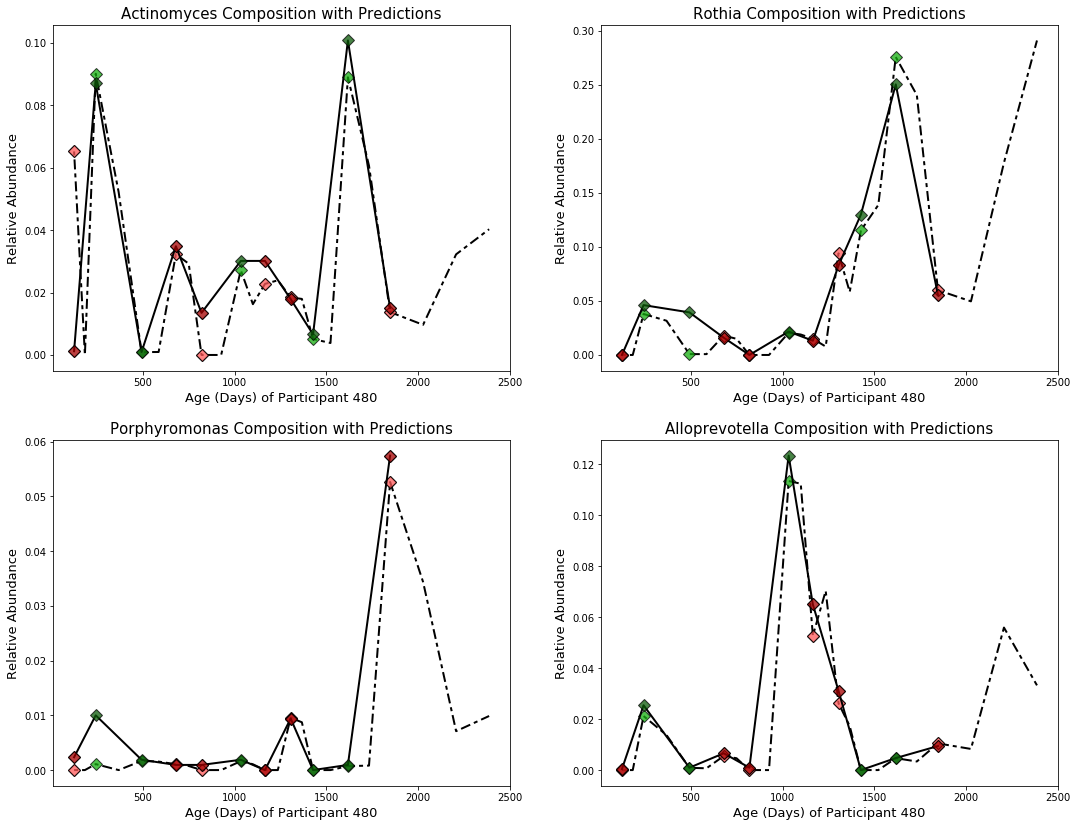

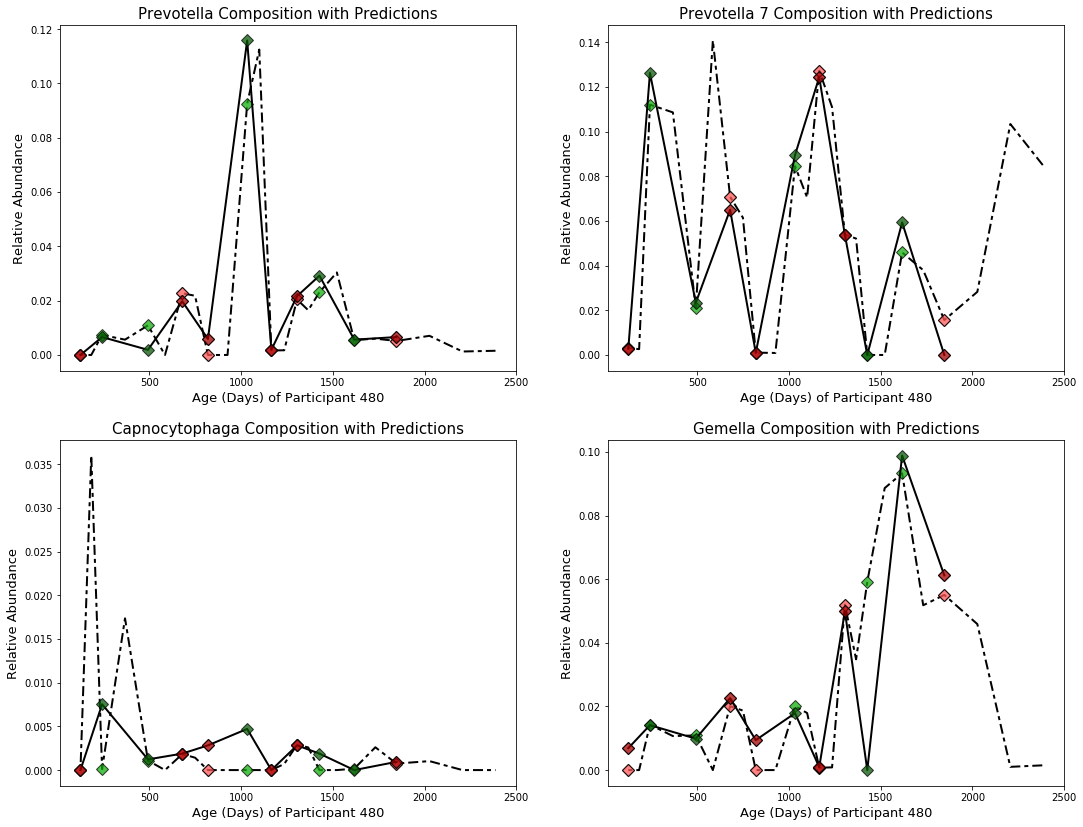

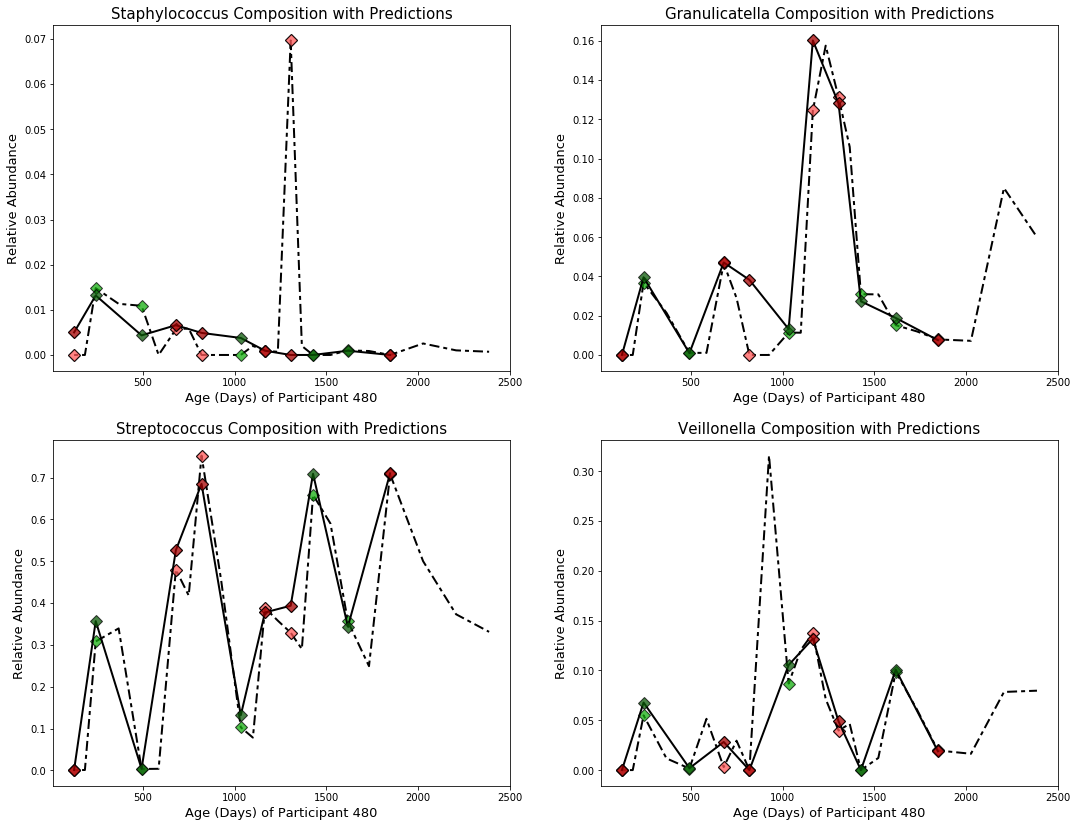

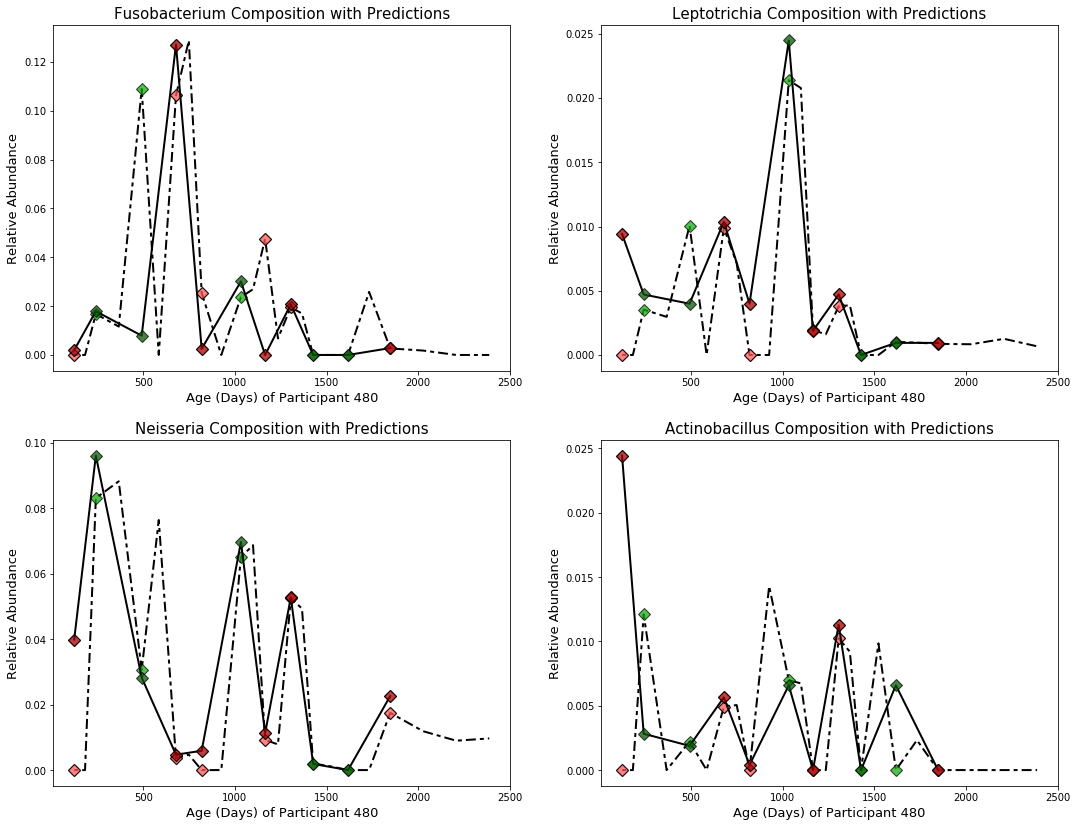

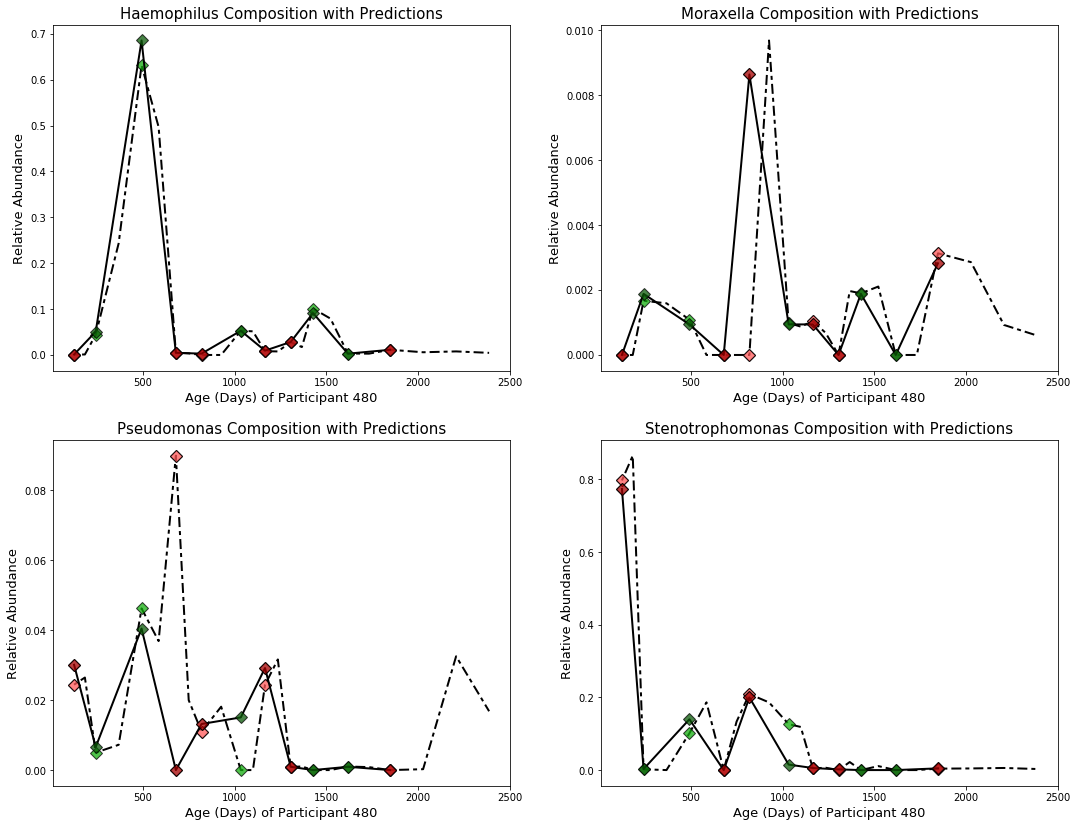

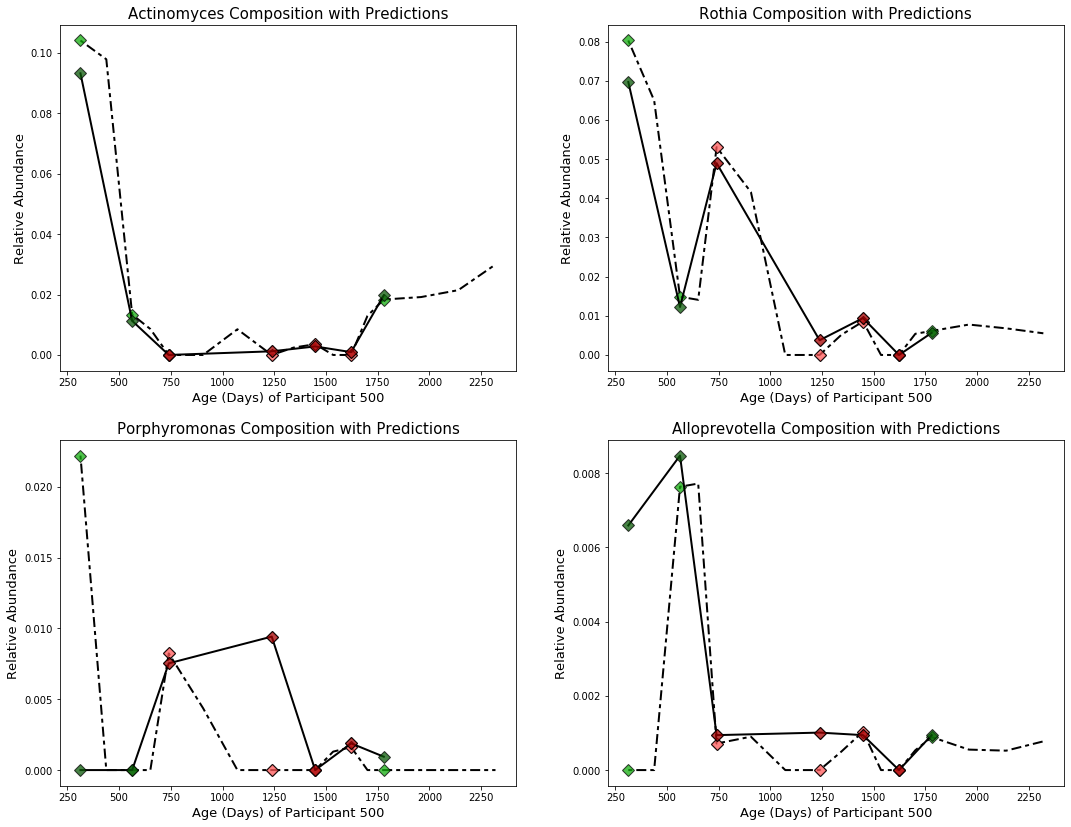

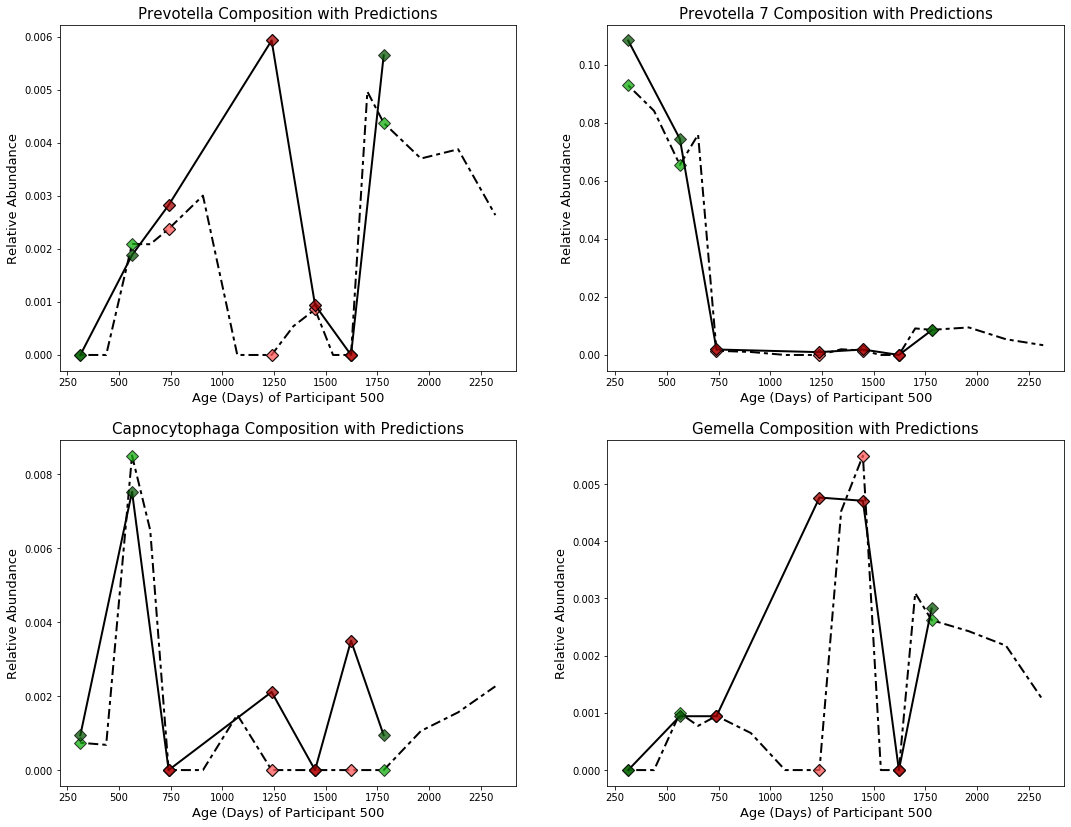

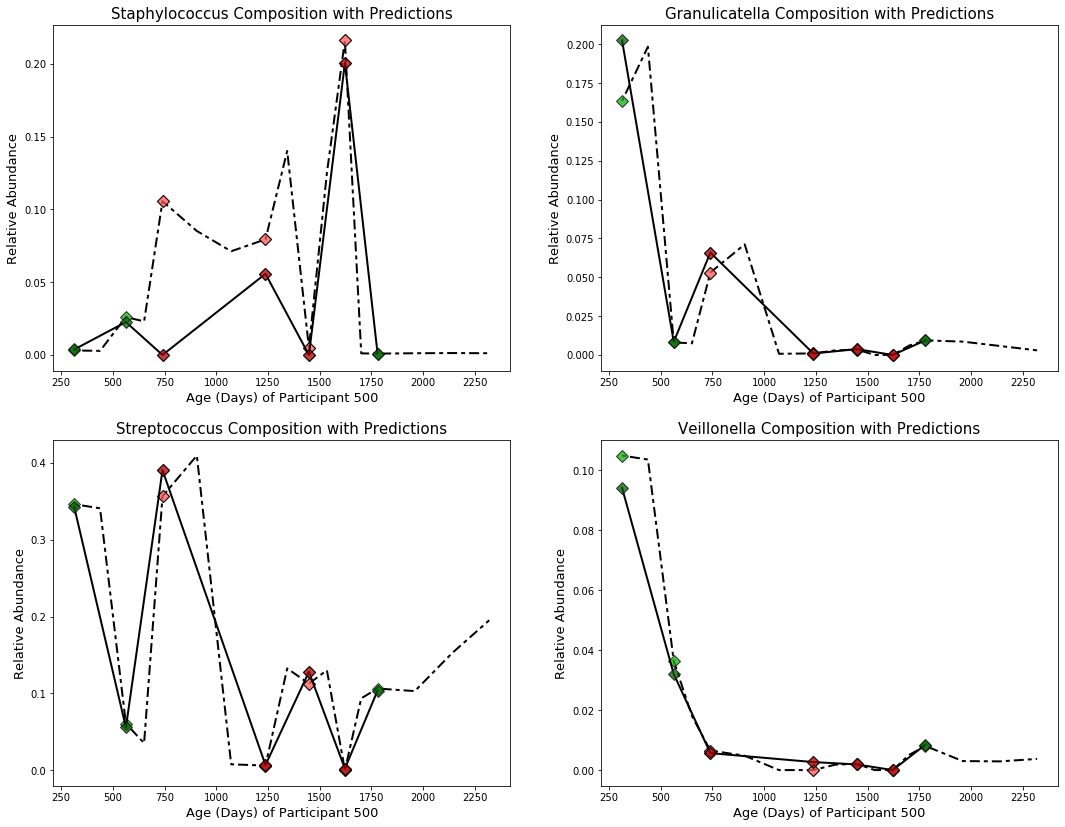

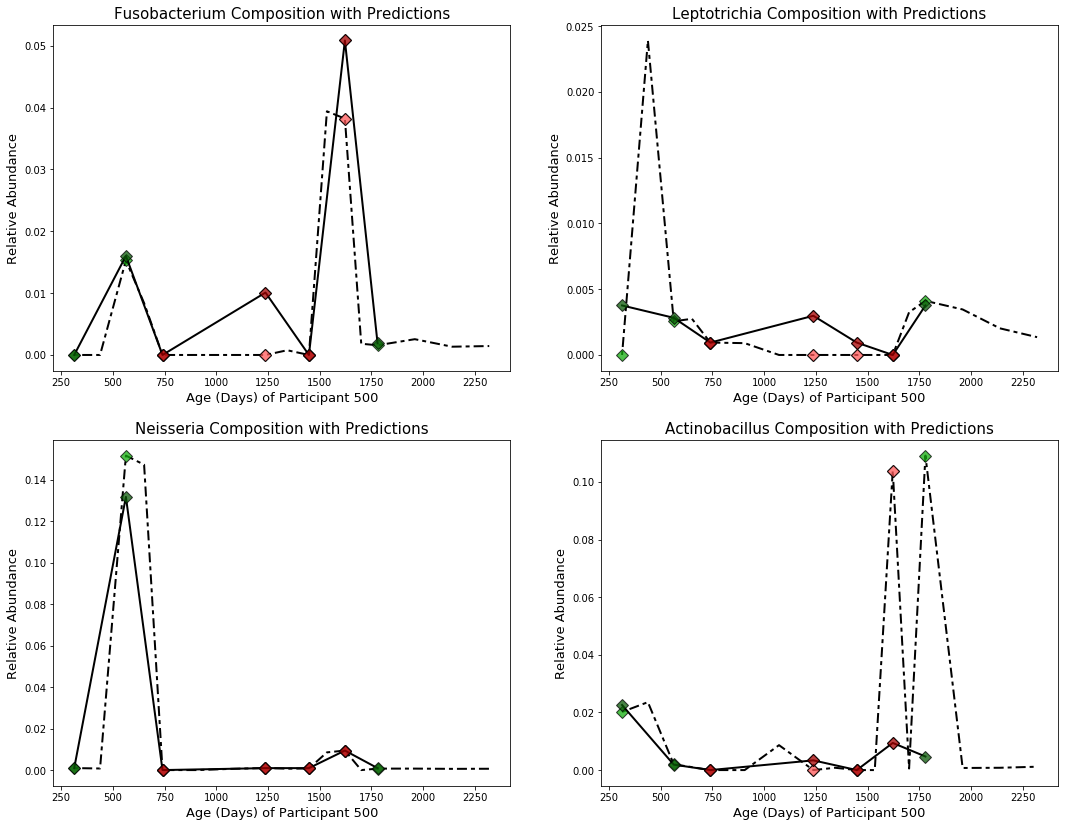

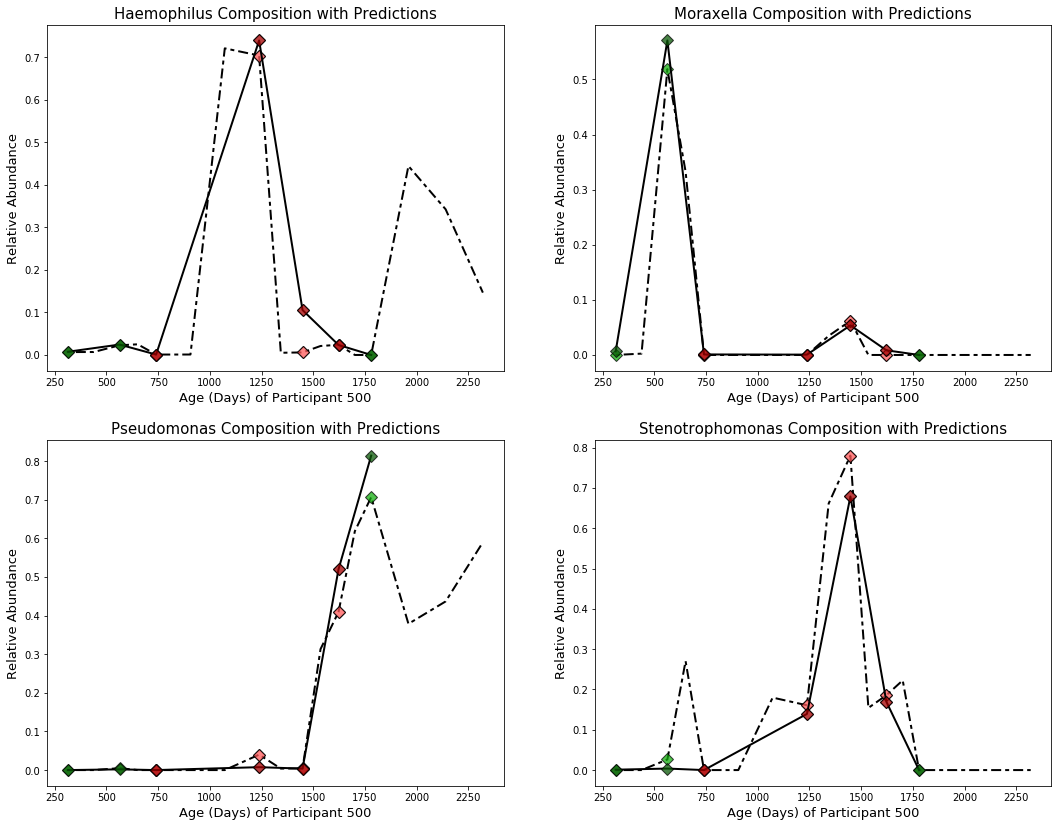

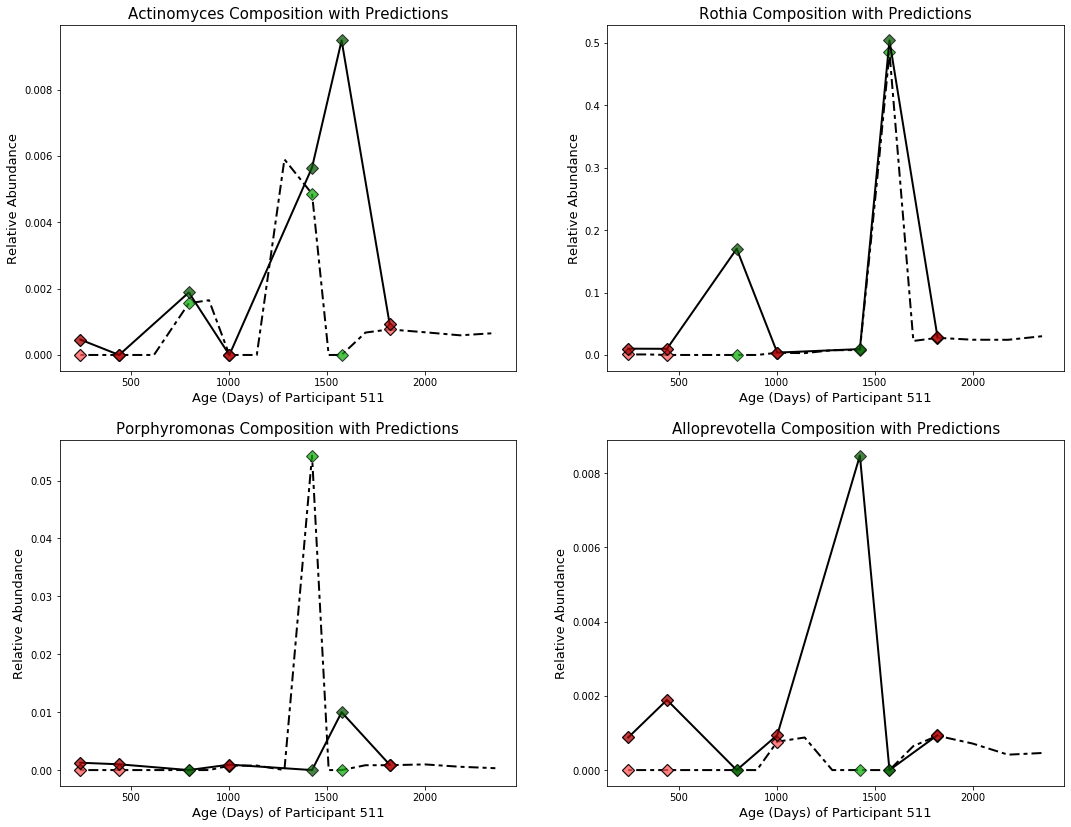

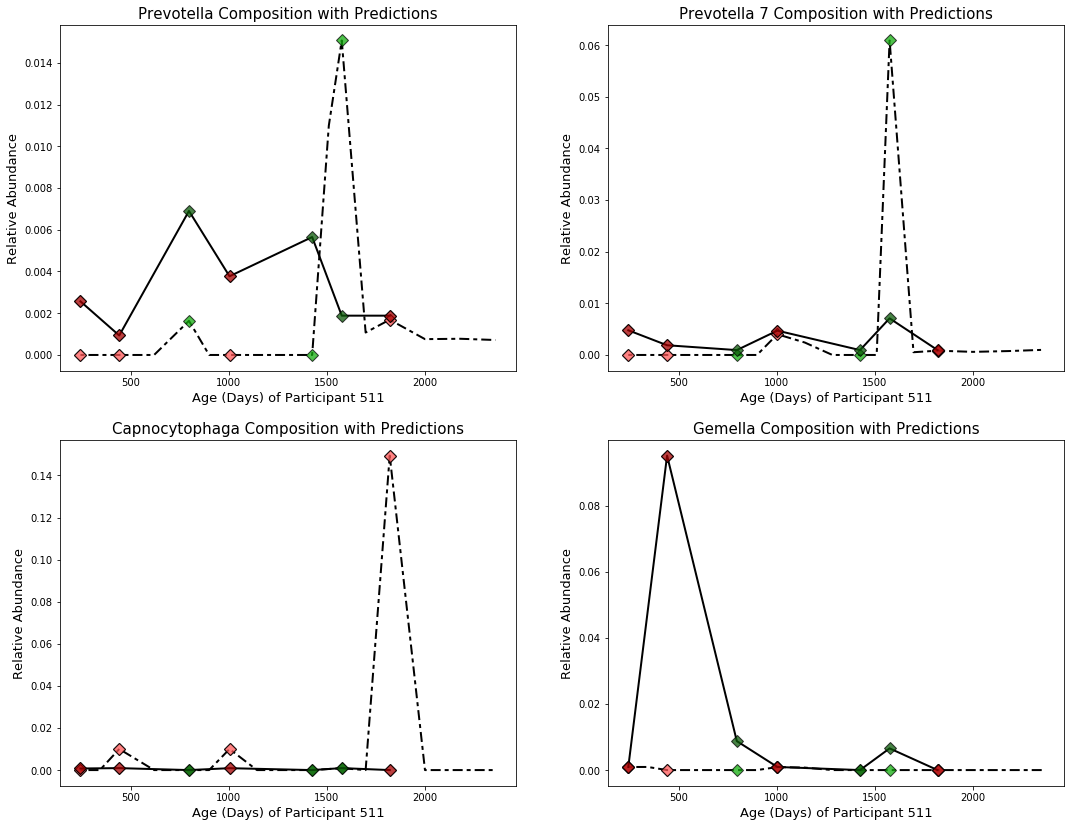

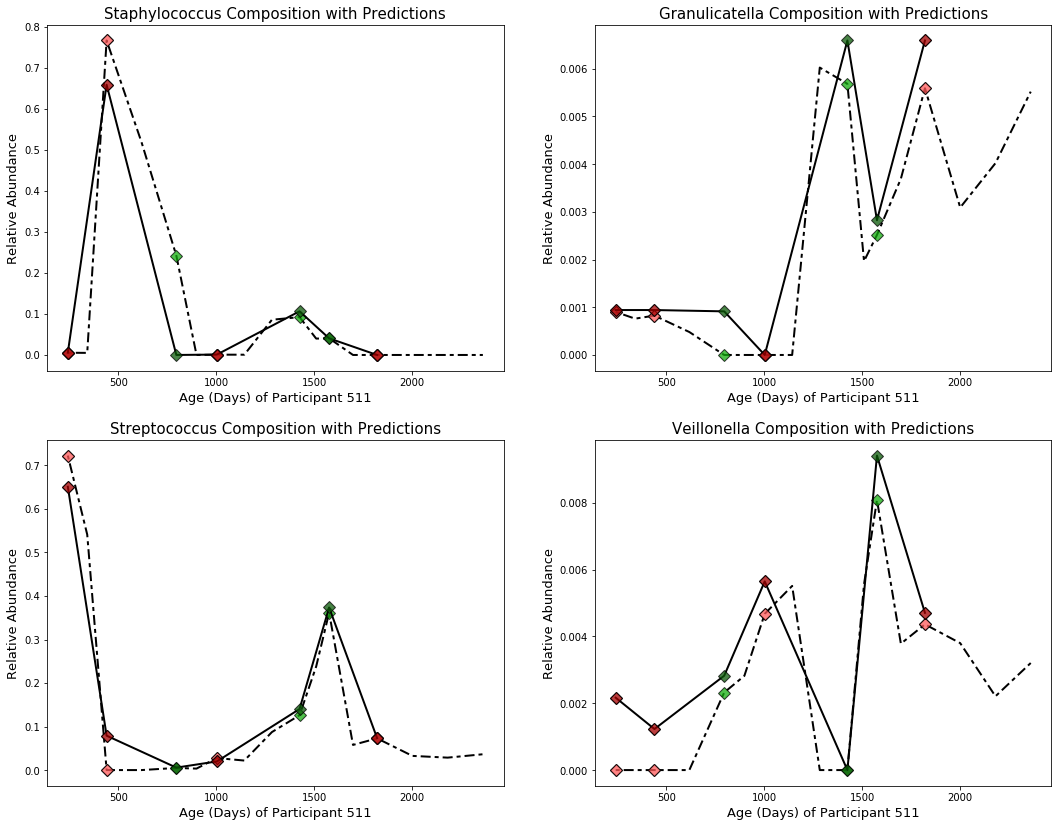

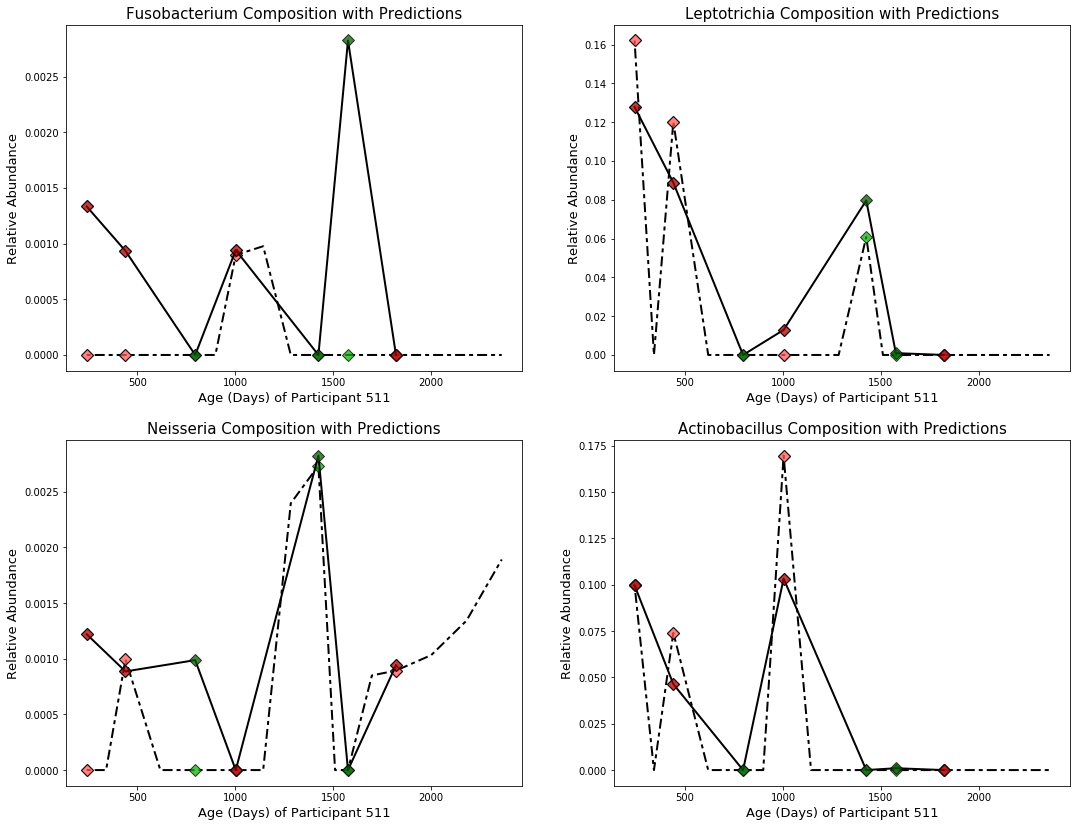

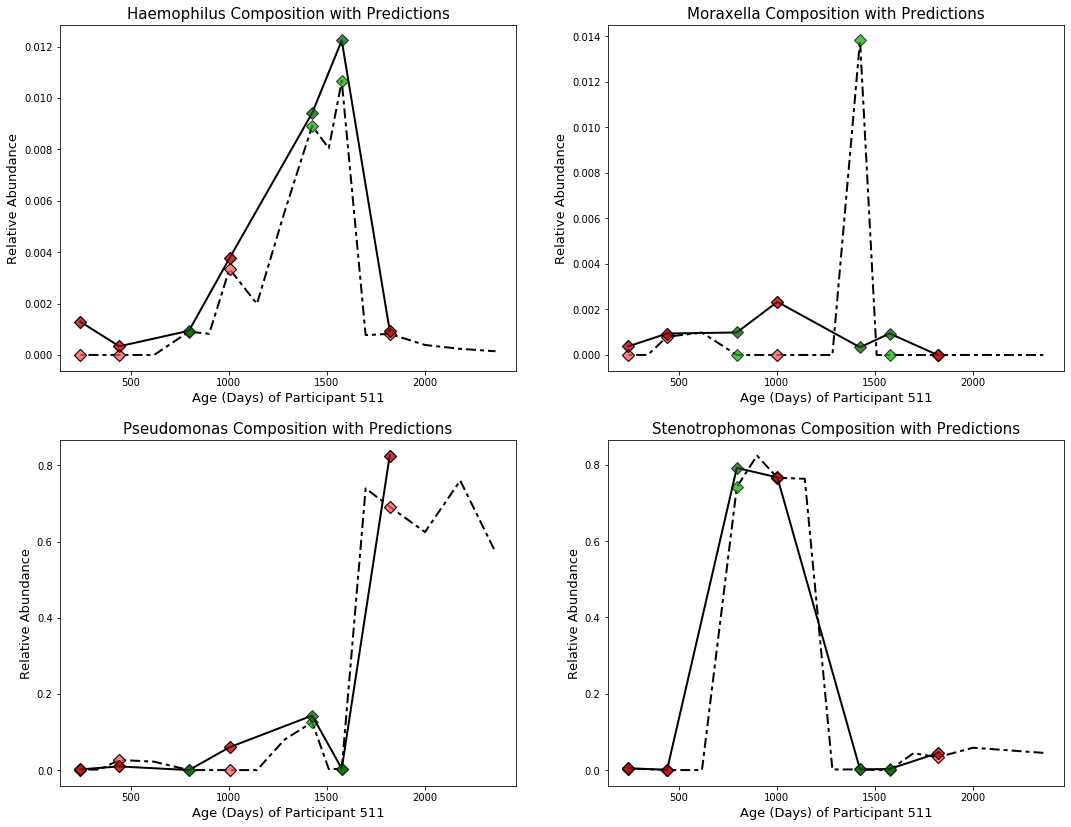

In [21]:
#run the function with predictions in a loop
for name in IDs:
    plot_pred_loop(name)

In [53]:
#function to plot just the predictions for the 3 most important bacteria in a row, using the dictionaries
def plot_pred_rows(name):
    rows=[94,113,229]
    markers_r = markers_rdict[name]
    markers_g = markers_gdict[name]
    markers_r1=markers_r1dict[name]
    markers_g1=markers_g1dict[name]
    r=reordered_dfs[name]
    rel=rel_dfs[name]
    days=[int(x) for x in rel.columns]
    ID=int(name) 
    fig=plt.figure(figsize=(26,7))
    for i in range(0,3):
        ax = fig.add_subplot(1,3,i+1)
        #because I made my markers slightly transparent, I need separate plots for lines and red markers
        #this avoids having the line become transparent
        #slightly transparent markers make it easier to see subtle differences between the lines
        #if you opt to set alpha at the default of 1 (not transparent), you can combine the first two red plots:
        #ax.plot(r.loc[0]+days[0], r.iloc[rows[i]],'-gD', markevery=markers_r1, markerfacecolor=l_red,markersize=8, 
                    #linewidth=2,dashes=[2, 2,5,2], c='black')                
        #there is no built-in way to customise marker colours by variables, so the green markers always need a dummy line          
        ax.plot(r.loc[0]+days[0], r.iloc[rows[i]],'-gD', markevery=markers_r1, markerfacecolor='none',markersize=8, 
                  linewidth=2,dashes=[2, 2,5,2], c='black')
        ax.plot(r.loc[0]+days[0], r.iloc[rows[i]],'-gD', markevery=markers_r1, markerfacecolor=l_red, alpha=0.75, 
                markersize=8, c='none')
        ax.plot(r.loc[0]+days[0], r.iloc[rows[i]],'-gD', markevery=markers_g1, markerfacecolor=l_green, alpha=0.75,
                markersize=8, c='none')
        #again, if you prefer alpha=1 you can combine the two lines for red markers:
        #ax.plot(days,rel.iloc[rows[i]-1],'-gD', markevery=markers_r,markerfacecolor=d_red, markersize=8, 
                    #linewidth=2, c='black')
        ax.plot(days, rel.iloc[rows[i]-1],'-gD', markevery=markers_r,markerfacecolor='none',markersize=8, 
                  linewidth=2, c='black')
        ax.plot(days, rel.iloc[rows[i]-1],'-gD', markevery=markers_r,markerfacecolor=d_red, alpha=0.75, markersize=8, 
                 c='none')
        ax.plot(days,rel.iloc[rows[i]-1],'-gD', markevery=markers_g,markerfacecolor=d_green,alpha=0.75, markersize=8, 
                   c='none')
        #optional: insert code from Section 6 to add a legend for each plot - you'll probably need to adjust it if you do
        plt.title('{} Composition with Predictions'.format(key['Name'][rows[i]-1]), size=24)
        plt.xlabel("Age (Days) of Participant {}".format(ID), size=18)
        plt.ylabel("Relative Abundance", size=18)
        plt.setp(ax.get_xticklabels(), size=14)
        plt.setp(ax.get_yticklabels(), size=14)
        #the tight_layout function reduces white space in the image. 
        #If you turn off tight_layout you may need to adjust your text size etc.          
        plt.tight_layout()        
        plt.savefig(r"F:\CF\Data\GPMicrobiome Data\{}_pred_rows.png".format(ID), format='png')
    plt.show()

In [ ]:
#run the function
plot_pred_rows('405')

In [55]:
#plotting with prediction for 2 in a row - simple edit to plot_pred_rows
def plot_pred_two(name):
    rows=[94,229]
    markers_r = markers_rdict[name]
    markers_g = markers_gdict[name]
    markers_r1 = markers_r1dict[name]
    markers_g1 = markers_g1dict[name] 
    r=reordered_dfs[name]
    rel=rel_dfs[name]
    days=[int(x) for x in rel.columns]
    ID=int(name) 
    fig=plt.figure(figsize=(15,6))
    for i in range(0,2):
        ax = fig.add_subplot(1,2,i+1)
        #because I made my markers slightly transparent, I need separate plots for lines and red markers
        #this avoids having the line become transparent
        #slightly transparent markers make it easier to see subtle differences between the lines
        #if you opt to set alpha at the default of 1 (not transparent), you can combine the first two red plots:
        #ax.plot(r.loc[0]+days[0], r.iloc[rows[i]],'-gD', markevery=markers_r1, markerfacecolor=l_red,markersize=8, 
                    #linewidth=2,dashes=[2, 2,5,2], c='black')                
        #there is no built-in way to customise marker colours by variables, so the green markers always need a dummy line          
        ax.plot(r.loc[0]+days[0], r.iloc[rows[i]],'-gD', markevery=markers_r1, markerfacecolor='none',markersize=8, 
                  linewidth=2,dashes=[2, 2,5,2], c='black')
        ax.plot(r.loc[0]+days[0], r.iloc[rows[i]],'-gD', markevery=markers_r1, markerfacecolor=l_red, alpha=0.75, 
                markersize=8, c='none')
        ax.plot(r.loc[0]+days[0], r.iloc[rows[i]],'-gD', markevery=markers_g1, markerfacecolor=l_green, alpha=0.75,
                markersize=8, c='none')  
        #again, if you prefer alpha=1 you can combine the two lines for red markers:
        #ax.plot(days,rel.iloc[rows[i]-1],'-gD', markevery=markers_r,markerfacecolor=d_red, markersize=8, 
                    #linewidth=2, c='black')
        ax.plot(days, rel.iloc[rows[i]-1],'-gD', markevery=markers_r,markerfacecolor='none',markersize=8, 
                  linewidth=2, c='black')
        ax.plot(days, rel.iloc[rows[i]-1],'-gD', markevery=markers_r,markerfacecolor=d_red, alpha=0.75, markersize=8, 
                 c='none')
        ax.plot(days,rel.iloc[rows[i]-1],'-gD', markevery=markers_g,markerfacecolor=d_green,alpha=0.75, markersize=8, 
                   c='none')
        #optional: insert code from Section 6 to add a legend for each plot - you'll probably need to adjust it if you do
        plt.title('{} Composition with Predictions'.format(key['Name'][rows[i]-1]), size=20)
        plt.xlabel("Age (Days) of Participant {}".format(ID), size=16)
        #alternative x axis label, if the participant's ID is in the title
        #plt.xlabel("Age(Days)", size=16)
        plt.ylabel("Relative Abundance", size=16)
        plt.setp(ax.get_xticklabels(), size=12)
        plt.setp(ax.get_yticklabels(), size=12)
        #the tight_layout function reduces white space in the image. 
        #If you turn off tight_layout you may need to adjust your text size etc.        
        plt.tight_layout()
        plt.savefig(r"F:\CF\Data\GPMicrobiome Data\{}_pred_two.png".format(ID), format='png')
    plt.show()

In [ ]:
#run the plot_pred_two function
plot_pred_two('405')

## Section 5: Alternative plotting functions
The next two functions will plot the output, with and without predictions, for individual participants if you don't want to use dictionaries and loops. 

<br>

These functions are nearly identical to the others, except for the manual input of parameters. As such, comments are kept to a minimum. For full explanatory comments see the loop versions of the functions. 

In [52]:
#function for output for data with one sample withheld, without predictions, inputting names of files manually as variable parameters
#s is the noise-free compositions file, rel is the relative abundance file, the markers are as explained above
#ID is the participant ID
#see the main versions of this function, plot_loop, for full explanatory comments
def plot(s, rel, markers_r, markers_g,ID):
    #divide the list of bacteria of interest into groups of 4 to facilitate plotting
    rows=[[2,30,58,59],[60,63,70,80],[94,104,113,167],[169,170,206,221],[223,227,229,234]]
    days=[int(x) for x in rel.columns]    
    #run a loop to plot each group of 4 in a 2 by 2 format with our custom markers, then save the file
    for j in range(0,5):
        fig = plt.figure(figsize=(18,14))
        for i in range(0,4):
            ax = fig.add_subplot(2,2,i+1)
            ax.plot(days, s.iloc[rows[j][i]],'-gD', markevery=markers_r, markerfacecolor='none',  
                    markersize=8, linewidth=2,dashes=[2, 2,5,2], c='black')
            ax.plot(days, s.iloc[rows[j][i]],'-gD', markevery=markers_r, markerfacecolor=l_red, alpha=0.75, 
                    markersize=8, c='none')     
            ax.plot(days, s.iloc[rows[j][i]],'-gD', markevery=markers_g, markerfacecolor=l_green, alpha=0.75,
                    markersize=8, c='none')          
            ax.plot(days,rel.iloc[rows[j][i]-1],'-gD', markevery=markers_r,markerfacecolor='none',markersize=8, 
                    linewidth=2, c='black')
            ax.plot(days,rel.iloc[rows[j][i]-1],'-gD', markevery=markers_r,markerfacecolor=d_red,alpha=0.75, markersize=8, 
                     c='none')
            ax.plot(days,rel.iloc[rows[j][i]-1],'-gD', markevery=markers_g,markerfacecolor=d_green,alpha=0.75, markersize=8, 
                    c='none') 
            #optional: insert code from Section 6 to add a legend for each plot - you'll probably need to adjust it if you do
            plt.title('{} Composition'.format(key['Name'][rows[j][i]-1]), size=15)
            plt.xlabel("Age (Days) of Participant {}".format(ID), size=13)
            plt.ylabel("Relative Abundance", size=13)
            plt.savefig(r"F:\CF\Data\GPMicrobiome Data\{}_{}.png".format(ID,j), format='png')
        plt.show()

In [53]:
#function with predictions included for individual files, inputting names of files manually as variable parameters
#r is the noise-free compositions with predictions file, and rel is the relative abundance file
#markers are as explained above, and ID is the participant ID
#see the main version of this function, plot_pred_loop, for full explanatory comments
def plot_pred(r, rel, markers_r, markers_g,markers_r1,markers_g1, ID):
    #divide the list of bacteria of interest into groups of 4 to facilitate plotting
    rows=[[2,30,58,59],[60,63,70,80],[94,104,113,167],[169,170,206,221],[223,227,229,234]]
    days=[int(x) for x in rel.columns]
    #run a loop to plot each group of 4 in a 2 by 2 format with our custom markers, then save the file
    for j in range(0,5):
        fig = plt.figure(figsize=(18,14))
        for i in range(0,4):
            ax = fig.add_subplot(2,2,i+1)
            ax.plot(r.loc[0]+days[0], r.iloc[rows[i]],'-gD', markevery=markers_r1, markerfacecolor='none',markersize=8, 
                  linewidth=2,dashes=[2, 2,5,2], c='black')
            ax.plot(r.loc[0]+days[0], r.iloc[rows[i]],'-gD', markevery=markers_r1, markerfacecolor=l_red, alpha=0.75, 
                markersize=8, c='none')
            ax.plot(r.loc[0]+days[0], r.iloc[rows[i]],'-gD', markevery=markers_g1, markerfacecolor=l_green, alpha=0.75,
                markersize=8, c='none')
            ax.plot(days, rel.iloc[rows[i]-1],'-gD', markevery=markers_r,markerfacecolor='none',markersize=8, 
                  linewidth=2, c='black')
            ax.plot(days, rel.iloc[rows[i]-1],'-gD', markevery=markers_r,markerfacecolor=d_red, alpha=0.75, markersize=8, 
                 c='none')
            ax.plot(days,rel.iloc[rows[i]-1],'-gD', markevery=markers_g,markerfacecolor=d_green,alpha=0.75, markersize=8, 
                   c='none')
            #optional: insert code from Section 6 to add a legend for each plot - you'll probably need to adjust it if you do
            plt.title('{} Composition with Predictions'.format(key['Name'][rows[j][i]-1]), size=15)
            plt.xlabel("Age (Days) of Participant {}".format(ID), size=13)
            plt.ylabel("Relative Abundance", size=13)
            plt.savefig(r"F:\CF\Data\GPMicrobiome Data\{}_pred_{}.png".format(ID,j), format='png')
        plt.show()

Should you wish to plot values which were predictions made between actual time points on their own with the observed values, the necessary edits to the functions should be pretty clear by now. You could read those files, which were created in readsample27 and you had the option to save, into a dictionary, then make the appropriate adjustments and substitutions to this program. Remember to turn the markers off for the predicted values because they are between actual time points and therefore the markers will not be valid.

In [ ]:
#example code for the extra dictionary
pred_dfs = {i: pd.read_csv('{}_pred.csv'.format(i)) for i in IDs}

## Section 6: Legends
Here we have code for creating legends for the plots in this program to be saved as separate files. Then we provide a template code which can be copied and pasted into the functions, then adjusted accordingly to give every plot its own legend. 

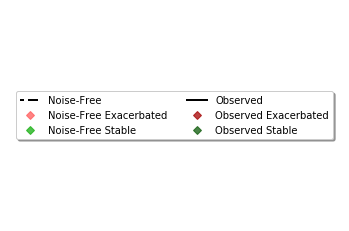

In [44]:
#create a legend for plots without predictions and save to a separate file using dummy plots
#you may already have this legend saved from the program Plots_for_Leave_One_Out_Data, in which case you can skip this
fig = plt.figure()
fig.patch.set_alpha(0.0)
ax = fig.add_subplot()
ax.plot([], [], linewidth=2, c='black',dashes=[2, 2,5,2], label="Noise-Free")
ax.plot([], [], 'gD', color=l_red,alpha=0.75,label="Noise-Free Exacerbated")
ax.plot([], [], 'gD', color=l_green,alpha=0.75,label="Noise-Free Stable")
ax.plot([], [], linewidth=2, c='black', label="Observed")
ax.plot([], [], 'gD', color=d_red,alpha=0.75,label="Observed Exacerbated")
ax.plot([], [], 'gD', color=d_green,alpha=0.75,label="Observed Stable")
ax.legend(loc='center', shadow=True, ncol=2)
plt.gca().set_axis_off()
plt.savefig(r"F:\CF\Data\GPMicrobiome Data\Basic_Legend.png", format='png')
plt.show()

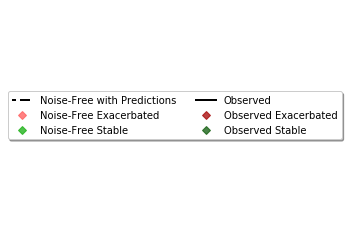

In [45]:
#create a legend for plots with predictions and save to a separate file using dummy plots
fig = plt.figure()
fig.patch.set_alpha(0.0)
ax = fig.add_subplot()
ax.plot([], [], linewidth=2, c='black',dashes=[2, 2,5,2], label="Noise-Free with Predictions")
ax.plot([], [], 'gD', color=l_red,alpha=0.75,label="Noise-Free Exacerbated")
ax.plot([], [], 'gD', color=l_green,alpha=0.75,label="Noise-Free Stable")
ax.plot([], [], linewidth=2, c='black', label="Observed")
ax.plot([], [], 'gD', color=d_red,alpha=0.75,label="Observed Exacerbated")
ax.plot([], [], 'gD', color=d_green,alpha=0.75,label="Observed Stable")
ax.legend(loc='center', shadow=True, ncol=2)
plt.gca().set_axis_off()
plt.savefig(r"F:\CF\Data\GPMicrobiome Data\Legend_with_Pred.png", format='png')
plt.show()

In [ ]:
#code to paste into the functions at the indicated places - legends for plots without predictions
#it is written to place the legend outside the plot, where it won't interfere
#you may wish to change the position of the legend box or make other adjustments to the figsize, or make other edits
#it is created using dummy plots with the same features as our actual plots
ax.plot([], [], linewidth=2, c='black',dashes=[2, 2,5,2], label="Noise-Free")
ax.plot([], [], 'gD', color=l_red,alpha=0.75,label="Noise-Free Exacerbated")
ax.plot([], [], 'gD', color=l_green,alpha=0.75,label="Noise-Free Stable")
ax.plot([], [], linewidth=2, c='black', label="Observed")
ax.plot([], [], 'gD', color=d_red,alpha=0.75,label="Observed Exacerbated")
ax.plot([], [], 'gD', color=d_green,alpha=0.75,label="Observed Stable")
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
#the tuple (1.25, 0.8) refers to the position relative to the width and height of the plot
ax.legend(loc='upper center', bbox_to_anchor=(1.25, 0.8), shadow=True, ncol=2)

In [ ]:
#code to paste into the functions at the indicated places - legends for plots with predictions
#it is written to place the legend outside the plot, where it won't interfere
#you may wish to change the position of the legend box or make other adjustments to the figsize, or make other edits
#it is created using dummy plots with the same features as our actual plots
ax.plot([], [], linewidth=2, c='black',dashes=[2, 2,5,2], label="Noise-Free with Predictions")
ax.plot([], [], 'gD', color=l_red,alpha=0.75,label="Noise-Free Exacerbated")
ax.plot([], [], 'gD', color=l_green,alpha=0.75,label="Noise-Free Stable")
ax.plot([], [], linewidth=2, c='black', label="Observed")
ax.plot([], [], 'gD', color=d_red,alpha=0.75,label="Observed Exacerbated")
ax.plot([], [], 'gD', color=d_green,alpha=0.75,label="Observed Stable")
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
#the tuple (1.25, 0.8) refers to the position relative to the width and height of the plot
ax.legend(loc='upper center', bbox_to_anchor=(1.25, 0.8), shadow=True, ncol=2)